# Function to compare individual curves with model simulations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Optional, Union, Any
import string

def plot_tumor_growth_comparison_grid(
                                excel_path: Union[str, List[str]],
                                exp_sheet_names: Optional[List[str]] = None,
                                sim_sheet_names: Optional[List[str]] = None,
                                Titles: Optional[List[str]] = None,
                                xlabels: Optional[List[str]] = None,
                                ylabels: Optional[List[str]] = None,
                                highlight_mouse_ids: Optional[List[Any]] = None,
                                mean_corrected_flags: Optional[List[bool]] = None,
                                points_on_mean_corrected_flags: Optional[List[bool]] = None,
                                show_mouse_id_flags: Optional[List[bool]] = None,
                                langs: Optional[List[str]] = None,
                                legend_fontsize: int = 12,
                                ymaxs: Optional[List[Optional[float]]] = None,
                                n_cols: int = 2,
                                figsize_per_plot: tuple = (6, 4),
                                sharex: bool = False,
                                sharey: bool = False,
                                constrained_layout: bool = True,
                                subplot_signs: Optional[List[str]] = None  # Новый параметр: обозначения подграфиков
                                ):
    """
    Строит сетку графиков сравнения экспериментальных данных и результатов моделирования.
    
    Parameters:
    -----------
    subplot_signs : List[str], optional
        Список обозначений для подграфиков (например, ['A', 'B', 'C', 'D']).
        Если None, используются буквы латинского алфавита по порядку.
        Если пустой список или список короче количества графиков, 
        для недостающих графиков используются буквы по порядку.
    """
    
    # Определяем количество графиков
    n_plots = 0
    if exp_sheet_names is not None:
        n_plots = max(n_plots, len(exp_sheet_names))
    if sim_sheet_names is not None:
        n_plots = max(n_plots, len(sim_sheet_names))
    if Titles is not None:
        n_plots = max(n_plots, len(Titles))
    
    if n_plots == 0:
        raise ValueError("Не указаны данные для построения графиков")
    
    # Подготавливаем обозначения подграфиков
    if subplot_signs is None:
        # По умолчанию используем буквы латинского алфавита
        subplot_signs = list(string.ascii_uppercase[:n_plots])
    elif len(subplot_signs) < n_plots:
        # Если переданных обозначений меньше, чем графиков, дополняем буквами
        existing_signs = subplot_signs.copy()
        # Начинаем с буквы, следующей за последней использованной
        if existing_signs:
            last_char = existing_signs[-1]
            if last_char in string.ascii_uppercase:
                start_idx = string.ascii_uppercase.index(last_char) + 1
            else:
                start_idx = 0
        else:
            start_idx = 0
        
        # Дополняем недостающие обозначения
        additional_signs = list(string.ascii_uppercase[start_idx:start_idx + (n_plots - len(existing_signs))])
        subplot_signs = existing_signs + additional_signs
    elif len(subplot_signs) > n_plots:
        # Обрезаем лишние обозначения
        subplot_signs = subplot_signs[:n_plots]
    
    # Подготавливаем списки параметров для каждого графика
    excel_paths = excel_path if isinstance(excel_path, list) else [excel_path] * n_plots
    
    exp_sheet_names = exp_sheet_names or [None] * n_plots
    sim_sheet_names = sim_sheet_names or [None] * n_plots
    Titles = Titles or [f"Tumor Growth Comparison {i+1}" for i in range(n_plots)]
    xlabels = xlabels or ["Days after tumor inoculation"] * n_plots
    ylabels = ylabels or ["Tumor volume, mm³"] * n_plots
    highlight_mouse_ids = highlight_mouse_ids or [None] * n_plots
    mean_corrected_flags = mean_corrected_flags or [False] * n_plots
    points_on_mean_corrected_flags = points_on_mean_corrected_flags or [False] * n_plots
    show_mouse_id_flags = show_mouse_id_flags or [False] * n_plots
    langs = langs or ["en"] * n_plots
    ymaxs = ymaxs or [None] * n_plots
    
    # Вычисляем количество строк и столбцов
    n_rows = (n_plots + n_cols - 1) // n_cols
    total_width = figsize_per_plot[0] * n_cols
    total_height = figsize_per_plot[1] * n_rows
    
    # Создаем сетку графиков
    fig, axes = plt.subplots(n_rows, n_cols, 
                             figsize=(total_width, total_height),
                             sharex=sharex, 
                             sharey=sharey,
                             squeeze=False,  # Всегда возвращаем массив, даже для 1 графика
                             constrained_layout=constrained_layout)
    
    # Преобразуем axes в плоский список для удобства итерации
    axes_flat = axes.flatten()
    
    # Строим каждый график
    for idx in range(n_plots):
        ax = axes_flat[idx]
        
        # Прямой вызов логики построения без создания промежуточной фигуры
        try:
            # Загружаем данные
            exp_df = None
            sim_df = None
            
            # Экспериментальные данные
            if exp_sheet_names[idx] is not None:
                try:
                    exp_df = pd.read_excel(excel_paths[idx], sheet_name=exp_sheet_names[idx])
                except Exception as e:
                    print(f"Ошибка загрузки экспериментальных данных для графика {idx+1}: {e}")
                    exp_df = None
            
            # Симулированные данные
            if sim_sheet_names[idx] is not None:
                try:
                    sim_df = pd.read_excel(excel_paths[idx], sheet_name=sim_sheet_names[idx])
                except Exception as e:
                    print(f"Ошибка загрузки симулированных данных для графика {idx+1}: {e}")
                    sim_df = None
            
            # Флаги для отслеживания
            has_normal_mouse = False
            has_highlighted_mouse = False
            mean_corrected_line = None
            mean_corrected_points = None
            sim_line = None
            all_y_values = []
            
            # Построение экспериментальных данных
            if exp_df is not None and len(exp_df) > 0:
                days = exp_df.columns[1:]
                
                for i in range(len(exp_df)):
                    mouse_id = exp_df.iloc[i, 0]
                    tumor_sizes = exp_df.iloc[i, 1:].values
                    
                    # Пропускаем mean_corrected для отдельной обработки
                    if mean_corrected_flags[idx] and str(mouse_id).lower() == 'mean_corrected':
                        continue
                    
                    # Проверяем, является ли ID числом
                    try:
                        float(mouse_id)
                        is_digit = True
                    except (ValueError, TypeError):
                        is_digit = False
                    
                    if not is_digit:
                        continue
                    
                    # Фильтруем NaN
                    valid_days = []
                    valid_sizes = []
                    
                    for day_idx, size in enumerate(tumor_sizes):
                        if not pd.isna(size):
                            valid_days.append(days[day_idx])
                            valid_sizes.append(size)
                            all_y_values.append(size)
                    
                    if len(valid_days) == 0:
                        continue
                    
                    # Определяем стиль линии
                    if highlight_mouse_ids[idx] is not None and mouse_id == highlight_mouse_ids[idx]:
                        color = 'b'
                        linewidth = 2
                        alpha = 1.0
                        has_highlighted_mouse = True
                    else:
                        color = 'k'
                        linewidth = 1
                        alpha = 0.7
                        has_normal_mouse = True
                    
                    # Рисуем линию
                    ax.plot(valid_days, valid_sizes, color=color, linewidth=linewidth, alpha=alpha)
                    
                    # Подписи мышей
                    if show_mouse_id_flags[idx] and len(valid_days) > 0:
                        last_day = valid_days[-1]
                        last_size = valid_sizes[-1]
                        text_x = last_day + 0.5
                        text_y = last_size
                        text_color = color
                        fontweight = 'bold' if highlight_mouse_ids[idx] is not None and mouse_id == highlight_mouse_ids[idx] else 'normal'
                        fontsize = 9 if highlight_mouse_ids[idx] is not None and mouse_id == highlight_mouse_ids[idx] else 8
                        
                        ax.text(text_x, text_y, str(mouse_id), 
                               color=text_color, fontsize=fontsize, fontweight=fontweight,
                               alpha=alpha, verticalalignment='center')
                
                # Скорректированное среднее
                if mean_corrected_flags[idx]:
                    for i in range(len(exp_df)):
                        mouse_id = exp_df.iloc[i, 0]
                        if str(mouse_id).lower() == 'mean_corrected':
                            tumor_sizes = exp_df.iloc[i, 1:].values
                            
                            valid_days = []
                            valid_sizes = []
                            
                            for day_idx, size in enumerate(tumor_sizes):
                                if not pd.isna(size):
                                    valid_days.append(days[day_idx])
                                    valid_sizes.append(size)
                                    all_y_values.append(size)
                            
                            if len(valid_days) > 0:
                                mean_corrected_line = ax.plot(
                                    valid_days, valid_sizes, 
                                    color='orange', 
                                    linewidth=3, 
                                    linestyle='--',
                                    alpha=0.9
                                )[0]
                                
                                if points_on_mean_corrected_flags[idx]:
                                    mean_corrected_points = ax.scatter(
                                        valid_days, valid_sizes,
                                        color='orange',
                                        s=30,
                                        edgecolors='orange',
                                        linewidth=1.5,
                                        zorder=5
                                    )
                            break
            
            # Симулированные данные
            if sim_df is not None and len(sim_df) > 0:
                if 'Day' in sim_df.columns and 'Tumor_Size' in sim_df.columns:
                    sim_line = ax.plot(sim_df['Day'], sim_df['Tumor_Size'], 'r-', linewidth=3)[0]
                    all_y_values.extend(sim_df['Tumor_Size'].values)
                else:
                    sim_line = ax.plot(sim_df.iloc[:, 0], sim_df.iloc[:, 1], 'r-', linewidth=3)[0]
                    all_y_values.extend(sim_df.iloc[:, 1].values)
            
            # Настройки графика
            ax.set_xlabel(xlabels[idx], fontsize=12)
            ax.set_ylabel(ylabels[idx], fontsize=12)
            ax.set_title(Titles[idx], fontsize=14)
            ax.grid(True, alpha=0.3)
            
            # Установка лимитов по Y
            if all_y_values:
                auto_ymax = max(all_y_values)
                auto_ymax_with_margin = auto_ymax * 1.1
            else:
                auto_ymax_with_margin = 100
            
            if ymaxs[idx] is not None:
                ax.set_ylim(top=ymaxs[idx])
            else:
                ax.set_ylim(top=auto_ymax_with_margin)
            
            # Создаем легенду
            legend_handles = []
            legend_labels = []
            
            # Индивидуальные мыши
            if has_normal_mouse:
                legend_handles.append(plt.Line2D([0], [0], color='k', linewidth=1, alpha=0.7))
                if langs[idx] == "en":
                    legend_labels.append("Individual mice")
                elif langs[idx] == "ru":
                    legend_labels.append("Отдельная мышь")
            
            # Выделенная мышь
            if has_highlighted_mouse:
                legend_handles.append(plt.Line2D([0], [0], color='b', linewidth=2, alpha=1.0))
                if langs[idx] == "en":
                    legend_labels.append("Validation mouse")
                elif langs[idx] == "ru":
                    legend_labels.append("Мышь для оптимизации")
            
            # Скорректированное среднее
            if mean_corrected_flags[idx] and mean_corrected_line is not None:
                if points_on_mean_corrected_flags[idx] and mean_corrected_points is not None:
                    legend_handles.append(plt.Line2D([0], [0], color='orange', linewidth=3, 
                                                    linestyle='--', alpha=0.9))
                else:
                    legend_handles.append(plt.Line2D([0], [0], color='orange', linewidth=3, 
                                                    linestyle='--', alpha=0.9))
                
                if langs[idx] == "en":
                    legend_labels.append("Mean Corrected")
                elif langs[idx] == "ru":
                    legend_labels.append("Скорректированное среднее")
            
            # Симуляция модели
            if sim_line is not None:
                legend_handles.append(sim_line)
                if langs[idx] == "en":
                    legend_labels.append("Model Simulation")
                elif langs[idx] == "ru":
                    legend_labels.append("Симуляция модели")
            
            # Добавляем легенду
            if legend_handles:
                ax.legend(legend_handles, legend_labels, loc='best', fontsize=legend_fontsize)
            
            # Добавляем обозначение подграфика (слева сверху)
            if idx < len(subplot_signs):
                sign = subplot_signs[idx]
                # Определяем положение текста (относительные координаты в пределах axes)
                ax.text(-0.1, 1.05, f"{sign}", transform=ax.transAxes,
                       fontsize=16, fontweight='bold', va='top', ha='right')
            
        except Exception as e:
            ax.text(0.5, 0.5, f"Ошибка в графике {idx+1}:\n{str(e)}", 
                   transform=ax.transAxes, ha='center', va='center',
                   fontsize=10, color='red')
            ax.set_title(f"График {idx+1} - Ошибка", fontsize=12, color='red')
    
    # Удаляем пустые графики
    for i in range(n_plots, len(axes_flat)):
        fig.delaxes(axes_flat[i])
    
    return fig

## Plots for monotherapies

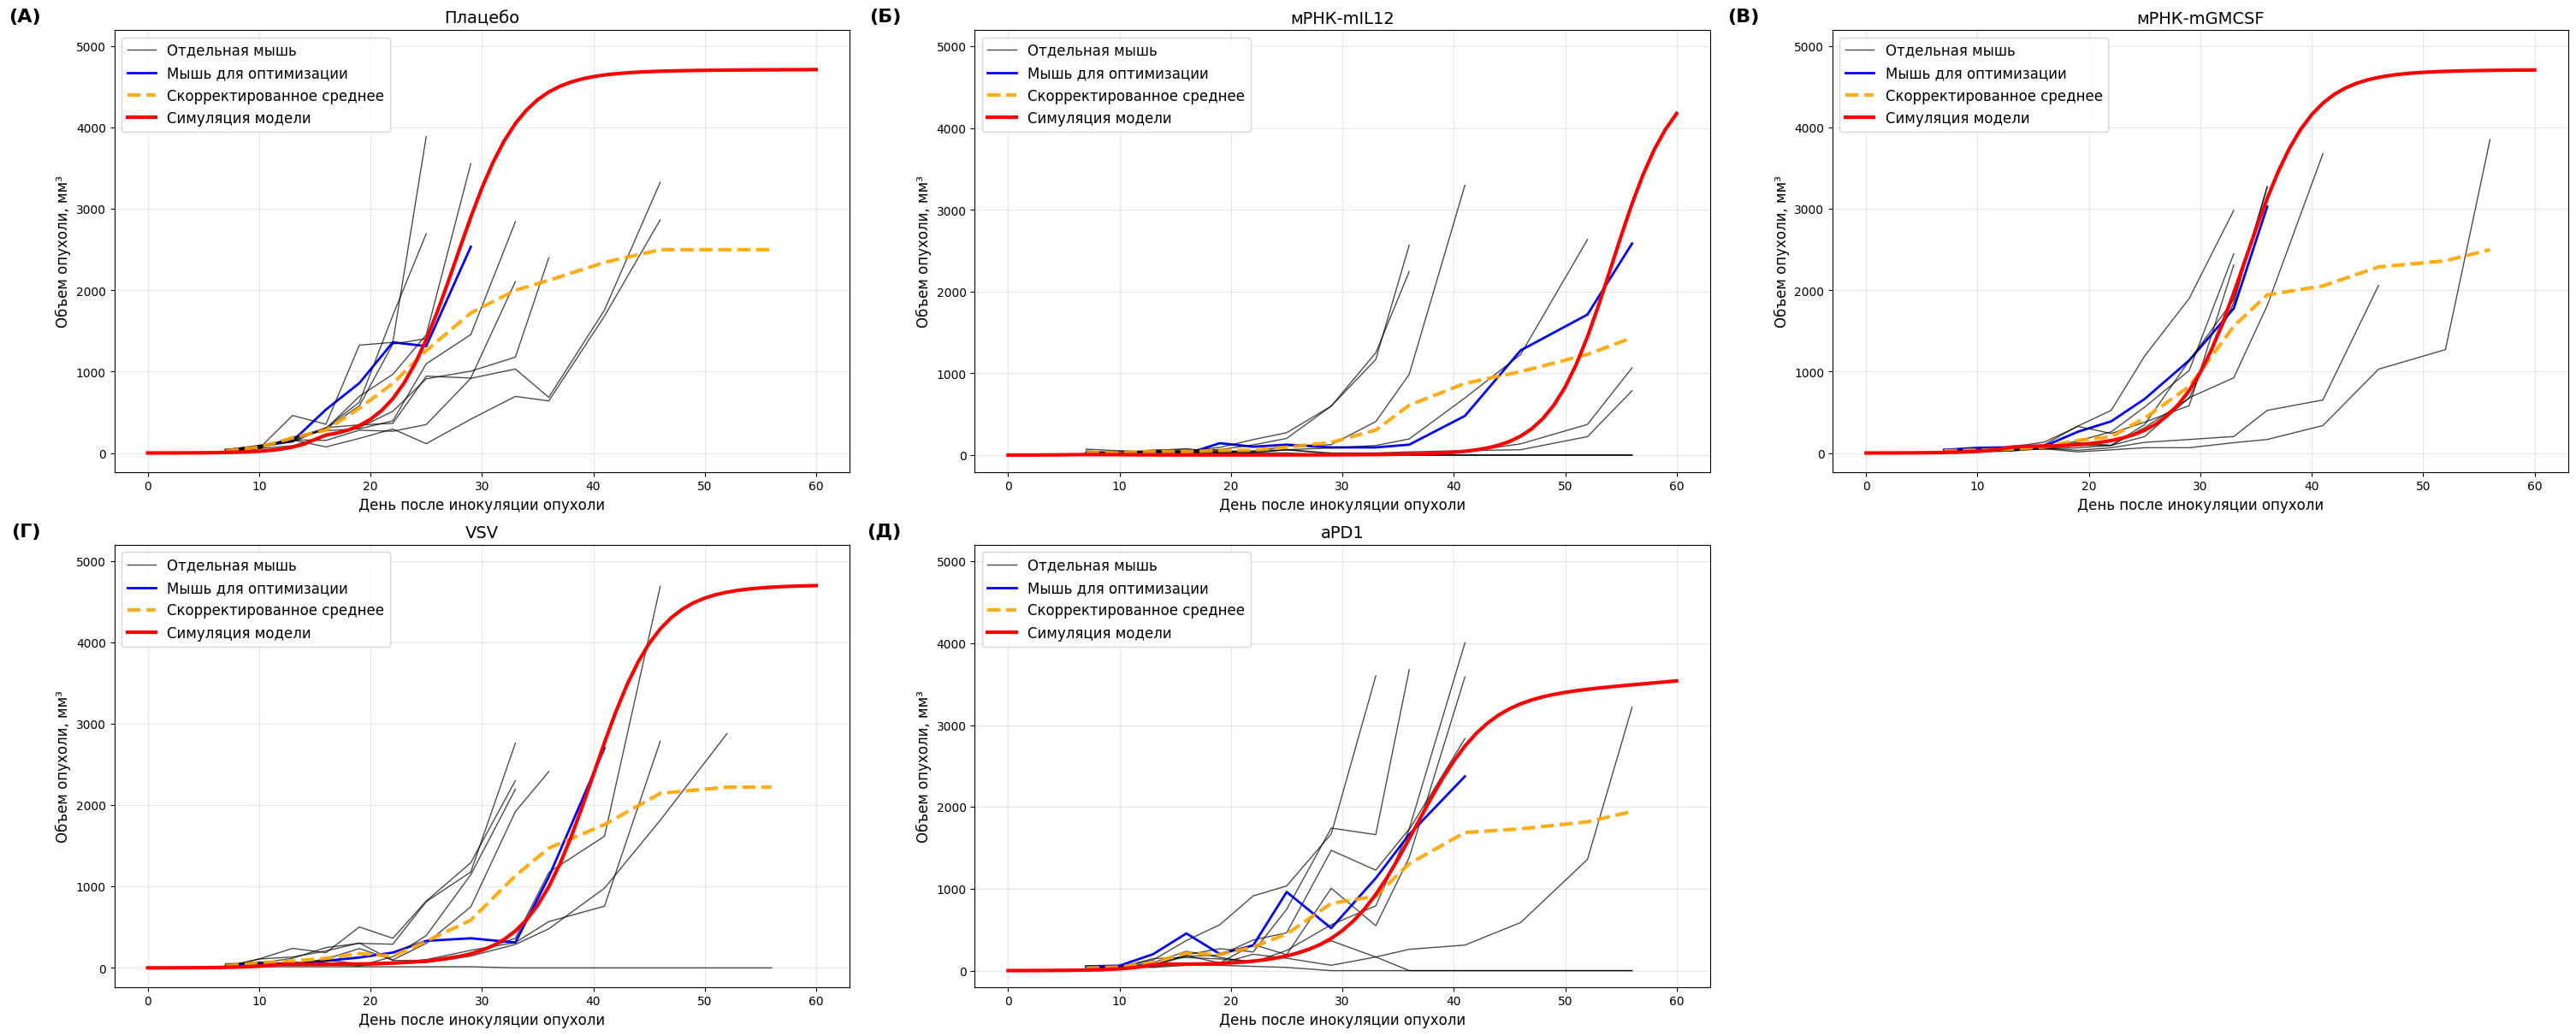

In [2]:
fig = plot_tumor_growth_comparison_grid(
                                excel_path = 'Tables/mouse_data_individual_curves.xlsx',
                                exp_sheet_names = ['PBS_exp', 'IL12_exp', 'GMCSF_exp', 'VSV_exp', 'aPD1_exp'],
                                sim_sheet_names = ['No_treatment_sim', 'IL12_sim', 'GMCSF_sim', 'VSV_sim', 'aPD1_sim'],
                                xlabels = ["День после инокуляции опухоли",
                                           "День после инокуляции опухоли",
                                           "День после инокуляции опухоли",
                                           "День после инокуляции опухоли",
                                           "День после инокуляции опухоли"],
                                ylabels=["Объем опухоли, мм³",
                                         "Объем опухоли, мм³",
                                         "Объем опухоли, мм³",
                                         "Объем опухоли, мм³",
                                         "Объем опухоли, мм³"],
                                Titles = ["Плацебо",
                                          "мРНК-mIL12",
                                          "мРНК-mGMCSF",
                                          "VSV",
                                          "aPD1"], 
                                highlight_mouse_ids = [1,1,1,6,6],
                                mean_corrected_flags = [True,True,True,True,True], 
                                points_on_mean_corrected_flags = [False,False,False,False,False],
                                show_mouse_id_flags = [False,False,False,False,False],
                                langs=["ru","ru","ru","ru","ru"],
                                ymaxs=[5200, 5200, 5200, 5200, 5200],
                                figsize_per_plot = (10, 6),
                                n_cols = 3,
                                subplot_signs=['(А)', '(Б)', '(В)', '(Г)', '(Д)']
                                )

## Plots for combinatorial regimens

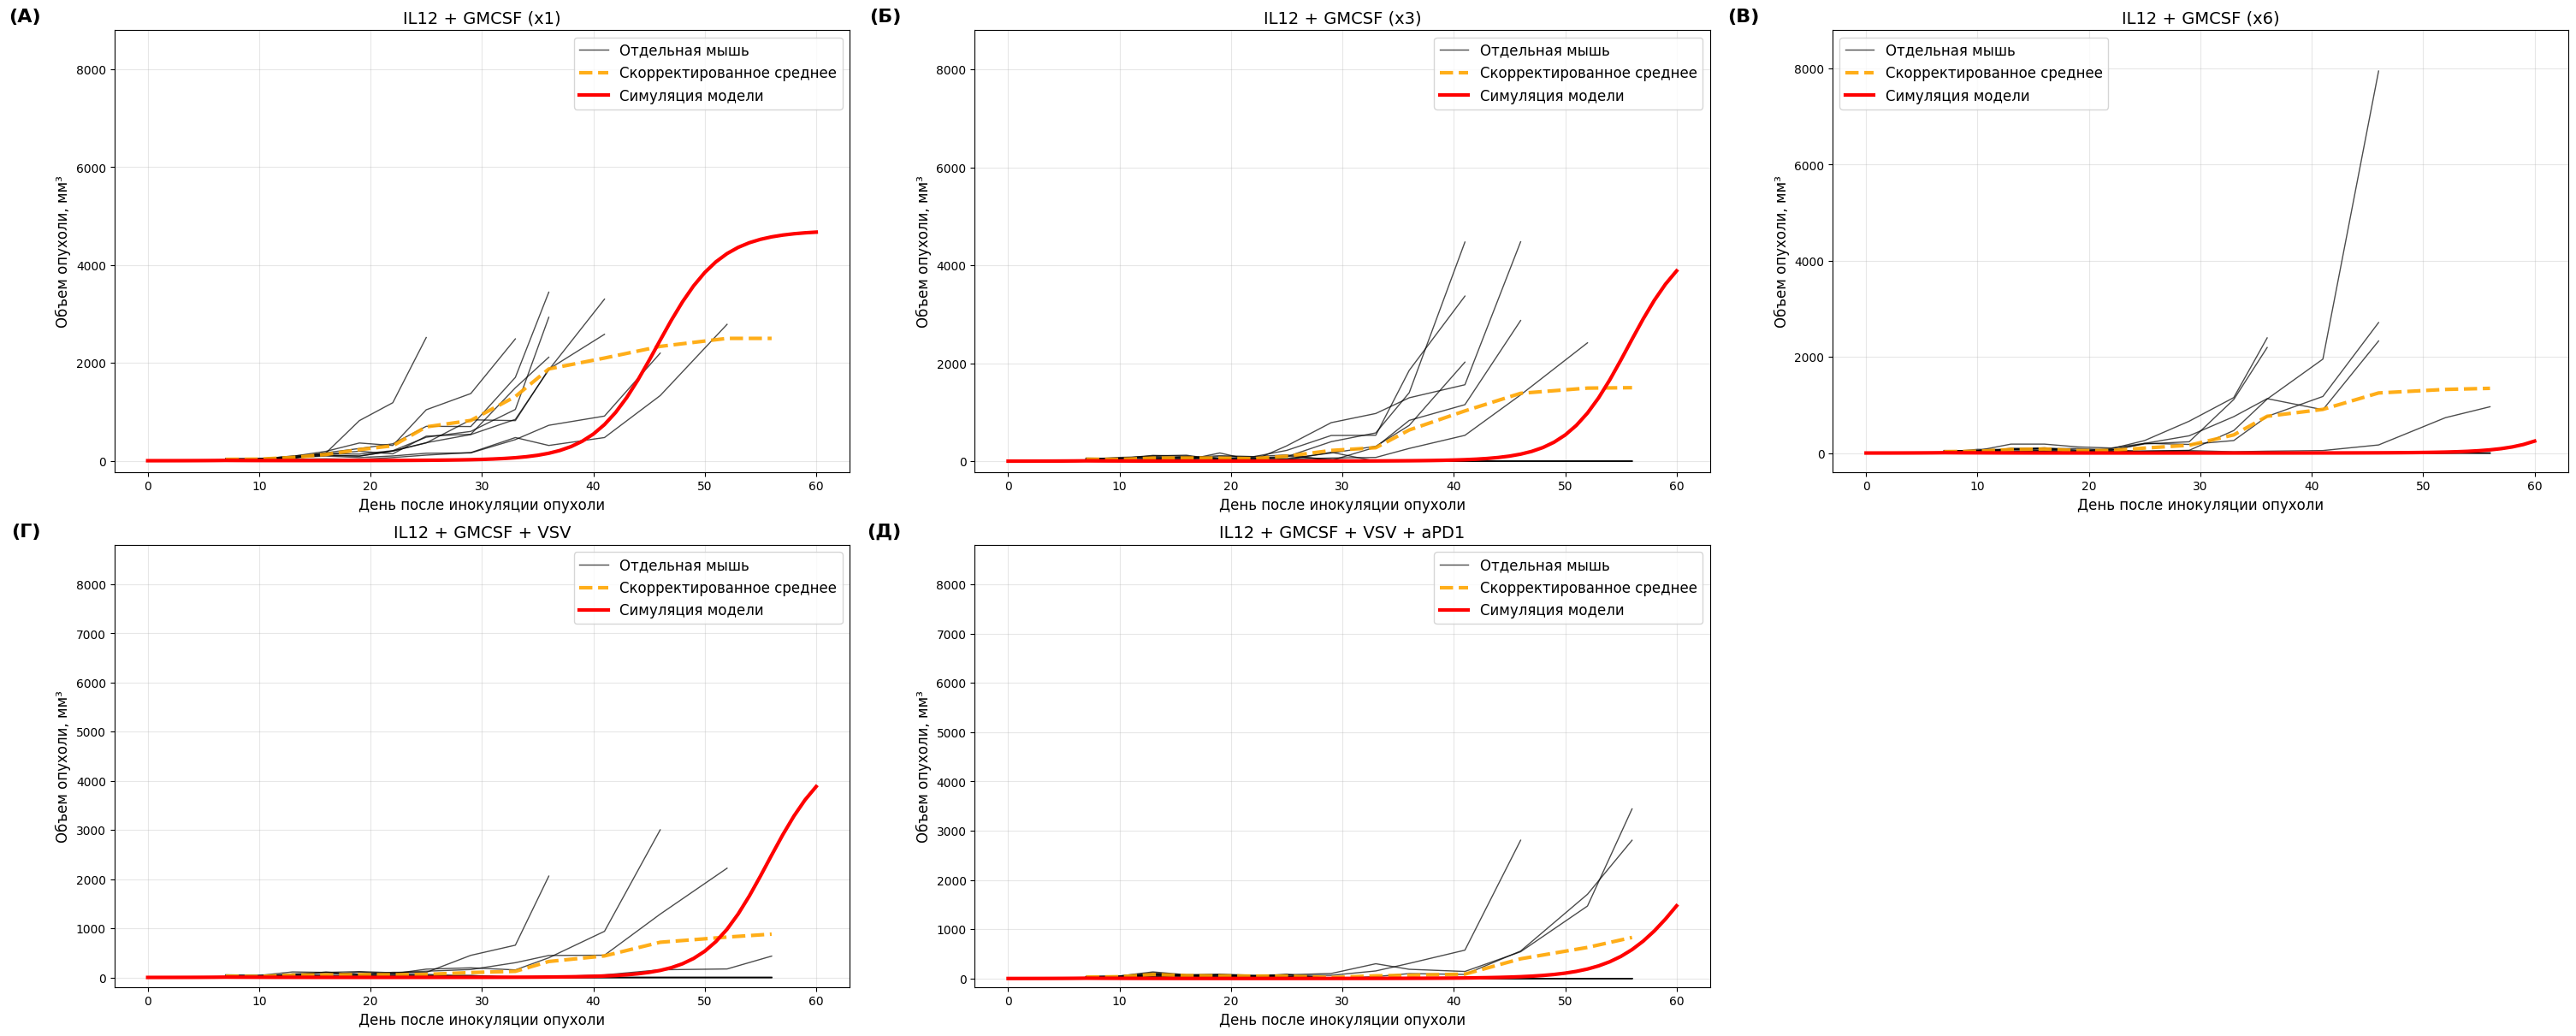

In [3]:
fig = plot_tumor_growth_comparison_grid(
                                excel_path = 'Tables/mouse_data_individual_curves.xlsx',
                                exp_sheet_names = ['IL12_GMCSF_x1_exp', 'IL12_GMCSF_x3_exp', 'IL12_GMCSF_x6_exp', 'IL12_GMCSF_VSV_exp', 'IL12_GMCSF_VSV_aPD1_exp'],
                                sim_sheet_names = ['IL12_GMCSF_x1_sim', 'IL12_GMCSF_x3_sim', 'IL12_GMCSF_x6_sim', 'IL12_GMCSF_VSV_sim', 'IL12_GMCSF_VSV_aPD1_sim'],
                                xlabels = ["День после инокуляции опухоли",
                                           "День после инокуляции опухоли",
                                           "День после инокуляции опухоли",
                                           "День после инокуляции опухоли",
                                           "День после инокуляции опухоли"],
                                ylabels=["Объем опухоли, мм³",
                                         "Объем опухоли, мм³",
                                         "Объем опухоли, мм³",
                                         "Объем опухоли, мм³",
                                         "Объем опухоли, мм³"],
                                Titles = ["IL12 + GMCSF (x1)",
                                          "IL12 + GMCSF (x3)",
                                          "IL12 + GMCSF (x6)",
                                          "IL12 + GMCSF + VSV",
                                          "IL12 + GMCSF + VSV + aPD1",], 
                                highlight_mouse_ids = [None,None,None,None,None],
                                mean_corrected_flags = [True,True,True,True,True], 
                                points_on_mean_corrected_flags = [False,False,False,False,False],
                                show_mouse_id_flags = [False,False,False,False,False],
                                langs=["ru","ru","ru","ru","ru"],
                                ymaxs=[8800, 8800, 8800, 8800, 8800],
                                figsize_per_plot = (10, 6),
                                n_cols = 3,
                                subplot_signs=['(А)', '(Б)', '(В)', '(Г)', '(Д)']
                                )

# Function to visualize sensetivity analysis result

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_subplots_from_excel(
    excel_file: str,
    sheet_name: str,
    ylabel: str,
    subplot_columns: list,
    subplot_titles: list,
    subplots_in_row: int = 2,
    plot_title: str = None,
    colors: list = None,
    param_captions: list = None,
    xlabel: str = None,
):
    """
    Строит столбчатые диаграммы на нескольких subplot'ах на основе данных из Excel.

    Параметры:
    ----------
    excel_file : str
        Путь к Excel-файлу.
    sheet_name : str
        Название листа в Excel-файле.
    plot_title : str
        Общий заголовок для всей фигуры.
    xlabel : str, optional
        Подпись оси X (единая для всех subplot'ов). Если None — не отображается.
    ylabel : str
        Подпись оси Y (единая для всех subplot'ов).
    subplot_columns : list of list of str
        Список списков столбцов. Каждый внутренний список — столбцы для одного subplot'а.
    subplot_titles : list of str
        Список заголовков для каждого subplot'а. Должен совпадать по длине с subplot_columns.
    colors : list, optional
        Список цветов для столбцов. Если None, используются цвета по умолчанию.
    subplots_in_row : int, optional (по умолчанию 2)
        Количество subplot'ов в одном ряду.
    param_captions : list of str, optional
        Список пояснений для параметров (столбцов) в порядке их следования в subplot_columns.
        Если длина меньше общего числа столбцов — подписываются только первые len(param_captions) параметров.
        Если None — подписи не добавляются.
    """
    # Проверка согласованности входных данных
    n_subplots = len(subplot_columns)
    if n_subplots == 0:
        raise ValueError("Список subplot_columns пуст.")
    if len(subplot_titles) != n_subplots:
        raise ValueError("Длина subplot_titles должна совпадать с длиной subplot_columns.")

    # Чтение данных
    df = pd.read_excel(excel_file, sheet_name=sheet_name)

    # Проверка наличия всех столбцов
    all_columns = [col for sublist in subplot_columns for col in sublist]
    missing = [col for col in all_columns if col not in df.columns]
    if missing:
        raise ValueError(f"Следующие столбцы отсутствуют в листе '{sheet_name}': {missing}")

    # Цвета по умолчанию
    if colors is None:
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                  '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
                  '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5']

    # Расчёт сетки
    rows = (n_subplots + subplots_in_row - 1) // subplots_in_row

    # Создание фигуры и осей
    fig, axes = plt.subplots(
        nrows=rows,
        ncols=subplots_in_row,
        figsize=(5 * subplots_in_row, 8 * rows),
        squeeze=False
    )
    if plot_title is not None:
        fig.suptitle(plot_title, fontsize=16)

    axes_flat = axes.flatten()

    # Глобальный индекс для отслеживания позиции в param_captions
    global_col_index = 0
    total_captions = len(param_captions) if param_captions is not None else 0

    # Построение каждого subplot'а
    for idx in range(n_subplots):
        ax = axes_flat[idx]
        cols = subplot_columns[idx]
        title = subplot_titles[idx]

        # Получаем данные из первой строки
        data = df[cols].iloc[0]
        values = data.values
        x_pos = np.arange(len(cols))

        # Цвета для текущего subplot'а
        subplot_colors = [colors[i % len(colors)] for i in range(len(cols))]

        # Строим столбцы
        bars = ax.bar(x_pos, values, width=0.8, color=subplot_colors)

        # Настройки осей
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel, fontsize = 14)
        ax.set_title(title, fontsize = 16)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(cols, rotation=45, ha='right', fontsize = 12)
        ax.axhline(y=0, color='black', linewidth=1)
        ax.tick_params(axis='x', which='both', length=0)

        # Добавляем подписи из param_captions, если заданы и есть для текущего столбца
        if param_captions is not None:
            for j, (x, val) in enumerate(zip(x_pos, values)):
                if global_col_index >= total_captions:
                    break
                if pd.isna(val):
                    global_col_index += 1
                    continue

                caption = param_captions[global_col_index]
                ylim = ax.get_ylim()
                y_range = ylim[1] - ylim[0]
                offset = 0.02 * y_range

                if val >= 0:
                    ax.text(x, -offset, caption, ha='center', va='top', fontsize=10)
                else:
                    ax.text(x, offset, caption, ha='center', va='bottom', fontsize=10)

                global_col_index += 1

    # Скрыть лишние subplot'ы
    for idx in range(n_subplots, len(axes_flat)):
        fig.delaxes(axes_flat[idx])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## Visualize sensetivity analysis result

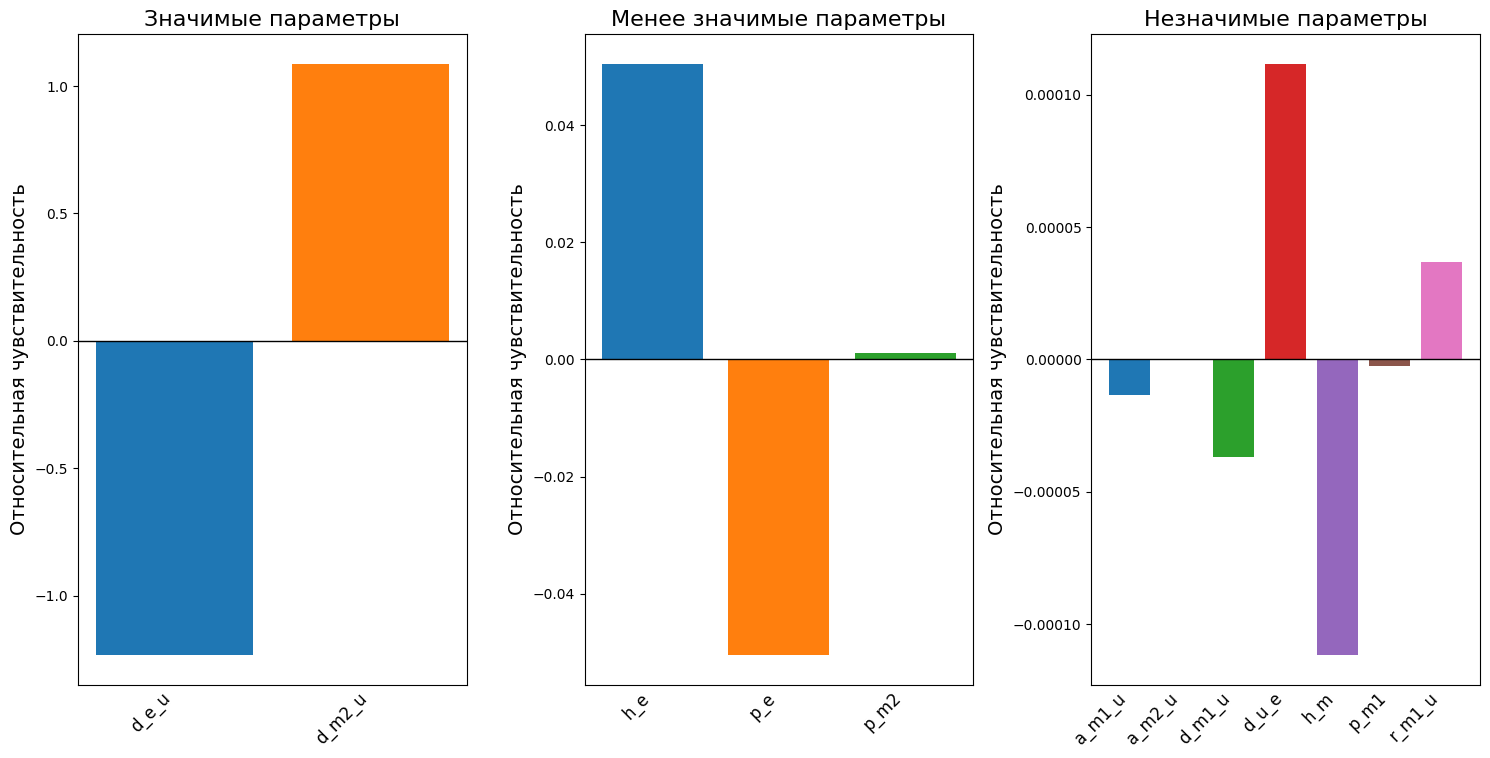

In [5]:
# Создаем график
data = plot_subplots_from_excel(
        excel_file = "Tables/Sensetivity analysis.xlsx",
        sheet_name = "Лист1",
        #plot_title="Sensitivity analysis",
        #xlabel="Parameters",
        ylabel="Относительная чувствительность",
        subplot_columns = [["d_e_u", "d_m2_u"], ["h_e", "p_e", "p_m2"], ["a_m1_u", "a_m2_u", "d_m1_u", "d_u_e", "h_m", "p_m1", "r_m1_u"]],
        subplot_titles = ["Значимые параметры", "Менее значимые параметры", "Незначимые параметры"],
        subplots_in_row = 3,
        #param_captions=['Cкорость уничтожения\n незараженных\n опухолевых клеток\n эффекторными\n T-клетками', 'Скорость поддержки\n роста незараженных\n опухолевых клеток\n M2-макрофагами']
        )

# Function to visualize objective function values for simulations with <i>d_e_u</i> and <i>d_m2_u</i> variations

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import FancyBboxPatch

def plot_grouped_ofv_comparison(excel_file, sheet_name='Лист1', orientation='vertical', 
                                figsize=(14, 8), value_format='scientific',
                                legend_labels=None,
                                extra_textbox=None,  # добавлен: дополнительный текст
                                extra_textbox_coor=(0.02, 0.98)  # добавлен: координаты текстового блока (x, y) в долях от размеров графика
                                ):
    """
    Строит сгруппированную столбчатую диаграмму сравнения OFV по методам лечения.
    
    Параметры:
    ----------
    excel_file : str
        Путь к Excel-файлу
    sheet_name : str, optional
        Название листа в Excel-файле (по умолчанию 'Лист1')
    orientation : str, optional
        Ориентация столбцов: 'vertical' (вертикальная) или 'horizontal' (горизонтальная)
        По умолчанию 'vertical'
    figsize : tuple, optional
        Размер фигуры (ширина, высота) в дюймах
    value_format : str, optional
        Формат отображения значений: 'scientific' (экспоненциальная форма) или 'standard' (стандартный)
    legend_labels : list of str, optional
        Массив подписей для легенды. Если None, используются названия из файла.
        Должен соответствовать количеству типов OFV.
    extra_textbox : str or list of str, optional
        Дополнительный текст для отображения на графике в виде текстового блока.
        Может быть строкой или списком строк.
    extra_textbox_coor : tuple, optional
        Координаты текстового блока (x, y) в долях от размеров графика (от 0 до 1).
        По умолчанию (0.02, 0.98) - левый верхний угол.
    """
    
    # Проверка допустимых значений параметров
    if orientation not in ['vertical', 'horizontal']:
        raise ValueError(f"Недопустимое значение orientation: '{orientation}'. "
                         f"Допустимые значения: 'vertical', 'horizontal'")
    
    if value_format not in ['scientific', 'standard']:
        raise ValueError(f"Недопустимое значение value_format: '{value_format}'. "
                         f"Допустимые значения: 'scientific', 'standard'")
    
    # Проверка координат текстового блока
    if not isinstance(extra_textbox_coor, (tuple, list)) or len(extra_textbox_coor) != 2:
        raise ValueError("extra_textbox_coor должен быть кортежем или списком из двух элементов")
    
    if not (0 <= extra_textbox_coor[0] <= 1 and 0 <= extra_textbox_coor[1] <= 1):
        raise ValueError("Координаты extra_textbox_coor должны быть в диапазоне от 0 до 1")
    
    # Загрузка данных
    df = pd.read_excel(excel_file, sheet_name=sheet_name, index_col=0)
    
    # Определяем названия методов лечения (исключаем служебные столбцы)
    treatment_methods = []
    for col in df.columns:
        if col not in ['Total','макс', ''] and not str(col).startswith('='):
            treatment_methods.append(col)
    
    # Фильтруем строки с OFV значениями
    ofv_rows = []
    ofv_labels = []
    for idx in df.index:
        if 'OFV' in str(idx):
            ofv_rows.append(idx)
            ofv_labels.append(idx)
    
    if not ofv_rows:
        raise ValueError("Не найдены строки с OFV значениями в данных")
    
    # Проверка и применение legend_labels
    if legend_labels is not None:
        if len(legend_labels) != len(ofv_labels):
            raise ValueError(f"Количество подписей в legend_labels ({len(legend_labels)}) "
                           f"не совпадает с количеством типов OFV ({len(ofv_labels)})")
        # Используем переданные подписи для легенды
        legend_titles = legend_labels
    else:
        # Используем исходные названия из файла
        legend_titles = ofv_labels
    
    # Извлекаем данные для графиков
    data = {}
    for method in treatment_methods:
        method_values = []
        for row in ofv_rows:
            value = df.loc[row, method]
            method_values.append(value)
        data[method] = method_values
    
    # Создаем DataFrame для удобства работы
    plot_df = pd.DataFrame(data, index=ofv_labels)
    
    # Параметры для графиков
    n_treatments = len(treatment_methods)  # количество методов лечения (11)
    n_ofv_types = len(ofv_labels)  # количество типов OFV (2)
    
    # Настройка положения столбцов
    if orientation == 'vertical':
        x = np.arange(n_treatments)  # позиции для групп
        width = 0.35  # ширина столбцов
        offset = width / 2  # смещение для второго столбца
    else:  # horizontal
        y = np.arange(n_treatments)
        height = 0.35
        offset = height / 2
    
    # Цвета для разных типов OFV
    colors = ['#1f77b4', '#ff7f0e']  # синий и оранжевый для двух типов OFV
    
    # Создание фигуры
    fig, ax = plt.subplots(figsize=figsize)
    
    # Рисование столбцов
    bars = []
    for i, (ofv_label, color, legend_title) in enumerate(zip(ofv_labels, colors, legend_titles)):
        values = plot_df.loc[ofv_label].values
        
        if orientation == 'vertical':
            positions = x - offset + i * width
            bar = ax.bar(positions, values, width, label=legend_title,  # <-- Используем legend_title
                         color=color, alpha=0.8, edgecolor='black')
        else:  # horizontal
            positions = y - offset + i * height
            bar = ax.barh(positions, values, height, label=legend_title,  # <-- Используем legend_title
                         color=color, alpha=0.8, edgecolor='black')
        
        bars.append(bar)
        
        # Добавление значений на столбцы (закомментировано, как в исходной функции)
        # for j, (pos, val) in enumerate(zip(positions, values)):
        #     if orientation == 'vertical':
        #         # Для вертикальных столбцов
        #         ax.text(pos, val + max(values) * 0.01, 
        #                f'{val:.2e}' if value_format == 'scientific' else f'{val:.0f}',
        #                ha='center', va='bottom', fontsize=9, rotation=90)
        #     else:
        #         # Для горизонтальных столбцов
        #         ax.text(val + max(values) * 0.01, pos,
        #                f'{val:.2e}' if value_format == 'scientific' else f'{val:.0f}',
        #                ha='left', va='center', fontsize=9)

    # Настройка осей и подписей
    if orientation == 'vertical':
        ax.set_xlabel('Метод терапии', fontsize=18)
        ax.set_ylabel('Значение целевой функции', fontsize=18)
        ax.set_xticks(x)
        ax.set_xticklabels(treatment_methods, fontsize=16, rotation=45, ha='right')
        ax.set_title('Сравнение целевой функции по методам лечения', fontsize=26, pad=20)
    else:
        ax.set_ylabel('Метод терапии', fontsize=16, fontweight='bold')
        ax.set_xlabel('Значение целевой функции', fontsize=16, fontweight='bold')
        ax.set_yticks(y)
        ax.set_yticklabels(treatment_methods, fontsize=10)
        #ax.set_title('Сравнение OFV по методам лечения', fontsize=14, fontweight='bold', pad=20)
    
    # Настройка форматирования значений на оси
    if value_format == 'scientific':
        if orientation == 'vertical':
            # Создаем кастомный форматтер, который отображает 0 как "0"
            def scientific_formatter(x, p):
                if abs(x) < 1e-10:  # проверяем, близко ли значение к нулю
                    return '0'
                else:
                    return f'{x:.1e}'
            ax.yaxis.set_major_formatter(FuncFormatter(scientific_formatter))
        else:
            # Создаем кастомный форматтер, который отображает 0 как "0"
            def scientific_formatter(x, p):
                if abs(x) < 1e-10:  # проверяем, близко ли значение к нулю
                    return '0'
                else:
                    return f'{x:.1e}'
            ax.xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
    
    # Добавление сетки
    if orientation == 'vertical':
        ax.yaxis.grid(True, alpha=0.3, linestyle='--')
    else:
        ax.xaxis.grid(True, alpha=0.3, linestyle='--')
    
    # Добавление легенды
    ax.legend(title='Варьируемый параметр', fontsize=16, title_fontsize=16, loc='upper right')
    
    # Добавление дополнительного текстового блока, если указан
    if extra_textbox is not None:
        # Преобразуем текст в список строк, если это не список
        if isinstance(extra_textbox, str):
            text_lines = [extra_textbox]
        elif isinstance(extra_textbox, list):
            text_lines = extra_textbox
        else:
            raise ValueError("extra_textbox должен быть строкой или списком строк")
        
        # Создаем текст с переносами строк
        text_content = '\n'.join(text_lines)
        
        # Параметры текстового блока
        bbox_props = dict(
            boxstyle="round,pad=0.5",  # скругленный прямоугольник
            facecolor="white",  # белый фон
            alpha=0.8,  # небольшая прозрачность
            edgecolor="black",  # черная рамка
            linewidth=1  # толщина рамки
        )
        
        # Добавляем текстовый блок
        ax.text(
            extra_textbox_coor[0],  # x координата
            extra_textbox_coor[1],  # y координата
            text_content,
            transform=ax.transAxes,  # координаты в долях от размеров графика
            fontsize=16,
            verticalalignment='top',  # выравнивание по верху
            horizontalalignment='left',  # выравнивание по левому краю
            bbox=bbox_props,
            fontfamily='monospace'  # моноширинный шрифт для лучшей читаемости
        )
    
    # Настройка отступов для предотвращения обрезания текста
    plt.tight_layout()
    
    # Добавление информации о данных
    print(f"Количество методов лечения: {n_treatments}")
    print(f"Методы лечения: {treatment_methods}")
    print(f"Типы OFV (исходные): {ofv_labels}")
    if legend_labels is not None:
        print(f"Подписи в легенде: {legend_labels}")
    else:
        print("Подписи в легенде: (использованы исходные названия)")
    
    if extra_textbox is not None:
        print(f"\nДополнительный текст на графике: {text_content}")
    
    print("\nЗначения OFV:")
    print(plot_df)
    
    plt.show()
    
    return fig, ax, plot_df

## Visualize objective function values for simulations with <i>d_e_u</i> and <i>d_m2_u</i> variations

Количество методов лечения: 10
Методы лечения: ['Плацебо', 'mIL12', 'mGMCSF', 'VSV', 'aPD1', 'mIL12-mGMCSF (x1)', 'mIL12-mGMCSF (x3)', 'mIL12-mGMCSF (x6)', 'mIL12-mGMCSF-VSV', 'mIL12-mGMCSF-VSV-aPD1']
Типы OFV (исходные): ['OFV_d_e_u', 'OFV_d_m2_u']
Подписи в легенде: ['d_e_u', 'd_m2_u']

Дополнительный текст на графике: ИТОГОВЫЙ РЕЗУЛЬТАТ
d_e_u (3.039e+06) < d_m2_u (5.953e+06)

Значения OFV:
                  Плацебо          mIL12         mGMCSF           VSV  \
OFV_d_e_u   137076.291938  220588.190320  163981.509669  1.610003e+05   
OFV_d_m2_u  205858.085481  248119.320511  306323.049310  1.965606e+06   

                    aPD1  mIL12-mGMCSF (x1)  mIL12-mGMCSF (x3)  \
OFV_d_e_u   3.115896e+05      863518.177443      346303.402491   
OFV_d_m2_u  1.382459e+06      642624.714721      404223.712846   

            mIL12-mGMCSF (x6)  mIL12-mGMCSF-VSV  mIL12-mGMCSF-VSV-aPD1  
OFV_d_e_u       501262.175593     164570.527116          168692.530118  
OFV_d_m2_u      465570.903850     17380

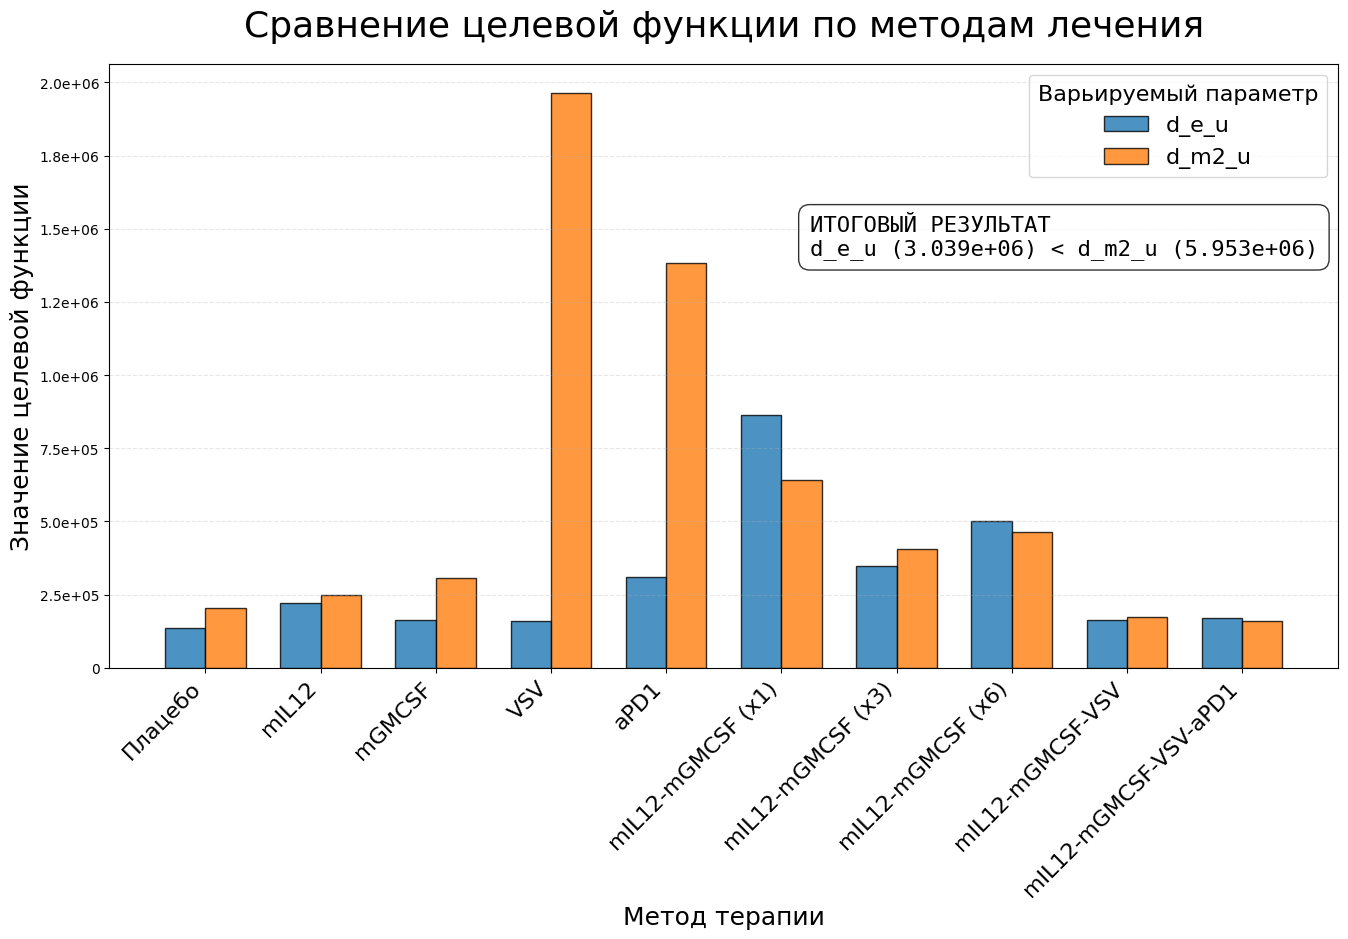

In [7]:
fig1, ax1, df1 = plot_grouped_ofv_comparison(
        excel_file='Tables/Compare_OFV.xlsx',
        sheet_name='Лист1',
        orientation='vertical',
        figsize=(14, 9.5),
        value_format='scientific',
        legend_labels = ['d_e_u', 'd_m2_u'],
        extra_textbox=[
        "ИТОГОВЫЙ РЕЗУЛЬТАТ",
        "d_e_u (3.039e+06) < d_m2_u (5.953e+06)",
        ],
        extra_textbox_coor=(0.57, 0.75)
    )

# Function to create one plot with many subplots

## Each subplot contains for every mouse:
<ul>
    <li>Experimental points</li>
    <li>First simulation result</li>
    <li>Second simulation result</li>
</ul>

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import transforms

def plot_all_mice_together_subplots_multifile(
    excel_files,  # ИЗМЕНЕНО: теперь список/массив файлов
    sheet_names_list,
    x_col_list,
    exp_col_list=None,  # ИЗМЕНЕНО: теперь опциональный параметр
    sim_col_list=None,  # ИЗМЕНЕНО: теперь опциональный параметр (но хотя бы один из exp_col_list или sim_col_list должен быть задан)
    sim2_col_list=None,
    plot_titles="",
    xlabels="",
    ylabels="",
    colors_list=None,
    exp_type_list=".",  # может быть списком или строкой
    y_upper_limits=None,
    legend_labels_list=None,
    legend_ncol=3,
    legend_fontsize=12,
    xlabel_fontsize=14,
    ylabel_fontsize=14,
    title_fontsize=20,
    plot_width=16,
    plot_height=12,
    legend_type="default",
    sim2_linestyle=":",
    sim2_linewidth=2,
    sim2_alpha=0.8,
    sim2_label_suffix=" (модель 2)",
    n_cols=2,
    subplot_figsize=None,
    subplot_signs=None,
    sharex=False,
    sharey=False,
    subplot_sign_fontsize=16,
    subplot_sign_fontweight='bold',
    subplot_sign_x_offset=-0.08,
    subplot_sign_y_offset=1.0,
    file_read_mode='per_subplot'  # добавлен: режим чтения файлов
):
    """
    Строит несколько графиков с данными по нескольким мышам в виде subplots.
    Теперь принимает массив файлов Excel (отдельный файл для каждого подграфика).
    
    Параметры:
    ----------
    excel_files : str or list of str
        Путь к Excel-файлу или список путей к Excel-файлам.
        Может быть:
        - Один файл (str): используется для всех подграфиков
        - Список файлов (list): отдельный файл для каждого подграфика
        - Список списков файлов: несколько файлов для каждого подграфика
    sheet_names_list : list of list of str
        Список списков имён листов для каждого подграфика.
    x_col_list : list of str
        Список названий столбцов с данными по оси X для каждого подграфика.
    exp_col_list : list of str or None, optional
        Список названий столбцов с экспериментальными данными для каждого подграфика.
        Если None, экспериментальные данные не отображаются.
    sim_col_list : list of str or None, optional
        Список названий столбцов с симуляционными данными (первая модель) для каждого подграфика.
        Если None, симуляционные данные первой модели не отображаются.
        Хотя бы один из exp_col_list или sim_col_list должен быть задан.
    sim2_col_list : list of str or None, optional
        Список названий столбцов с симуляционными данными второй модели для каждого подграфика.
    plot_titles : str or list of str
        Заголовки графиков. Если строка - будет использоваться для всех подграфиков.
    xlabels : str or list of str
        Подписи оси X. Если строка - будет использоваться для всех подграфиков.
    ylabels : str or list of str
        Подписи оси Y. Если строка - будет использоваться для всех подграфиков.
    colors_list : list of list of str or None
        Список списков цветов для каждого подграфика.
    exp_type_list : str or list of str, optional
        Тип отображения экспериментальных данных для каждого подграфика.
        "." — точки, "--" — пунктирная линия.
    y_upper_limits : float or list of float or None, optional
        Верхние пределы оси Y для каждого подграфика.
    legend_labels_list : list of list of str or None, optional
        Произвольные названия для легенды для каждого подграфика.
    legend_ncol : int, optional
        Количество колонок в легенде (по умолчанию 3).
    legend_fontsize : int, optional
        Размер шрифта легенды (по умолчанию 12).
    xlabel_fontsize : int, optional
        Размер шрифта подписи оси X (по умолчанию 14).
    ylabel_fontsize : int, optional
        Размер шрифта подписи оси Y (по умолчанию 14).
    title_fontsize : int, optional
        Размер шрифта заголовка (по умолчанию 20).
    plot_width : int, optional
        Ширина общего графика в дюймах (по умолчанию 16).
    plot_height : int, optional
        Высота общего графика в дюймах (по умолчанию 12).
    legend_type : str or list of str, optional
        Тип легенды для каждого подграфика:
        - "default": стандартная легенда со всеми мышами снизу
        - "simple": упрощенная легенда на графике
    sim2_linestyle : str or list of str, optional
        Стиль линии для второй модели симуляции для каждого подграфика.
    sim2_linewidth : float or list of float, optional
        Толщина линии для второй модели для каждого подграфика.
    sim2_alpha : float or list of float, optional
        Прозрачность линии для второй модели для каждого подграфика.
    sim2_label_suffix : str or list of str, optional
        Суффикс для легенды второй модели для каждого подграфика.
    n_cols : int, optional
        Количество подграфиков в одном ряду (по умолчанию 2).
    subplot_figsize : tuple or None, optional
        Размер каждого подграфика в дюймах (ширина, высота). Если None, вычисляется автоматически.
    subplot_signs : list of str or None, optional
        Обозначения подграфиков (А, Б, В и т.д.). Если None, не отображаются.
    sharex : bool, optional
        Если True, все подграфики будут иметь общую ось X (по умолчанию False).
    sharey : bool, optional
        Если True, все подграфики будут иметь общую ось Y (по умолчанию False).
    subplot_sign_fontsize : int, optional
        Размер шрифта для обозначений подграфиков (по умолчанию 16).
    subplot_sign_fontweight : str, optional
        Жирность шрифта для обозначений (по умолчанию 'bold').
    subplot_sign_x_offset : float, optional
        Смещение обозначений по оси X относительно левого края (по умолчанию -0.15).
        Отрицательные значения - смещение влево, положительные - вправо.
    subplot_sign_y_offset : float, optional
        Смещение обозначений по оси Y относительно верхнего края (по умолчанию 1.0).
        Значения > 1.0 - смещение вверх, < 1.0 - смещение вниз.
    file_read_mode : str, optional
        Режим чтения файлов:
        - 'per_subplot': отдельный файл для каждого подграфика (по умолчанию)
        - 'shared': один файл для всех подграфиков
        - 'per_mouse': отдельный файл для каждой мыши в каждом подграфике
    """
    
    # Проверка: хотя бы один из exp_col_list или sim_col_list должен быть задан
    if exp_col_list is None and sim_col_list is None:
        raise ValueError("Хотя бы один из параметров exp_col_list или sim_col_list должен быть задан")
    
    # Определяем количество подграфиков
    n_plots = len(sheet_names_list)
    
    # Обработка параметра excel_files
    if isinstance(excel_files, str):
        # Один файл для всех подграфиков
        excel_files = [excel_files] * n_plots
        file_read_mode = 'shared'
    elif isinstance(excel_files, list):
        if len(excel_files) != n_plots:
            # Проверяем, может быть это список списков (несколько файлов для каждого подграфика)
            if all(isinstance(f, list) for f in excel_files):
                if len(excel_files) == n_plots:
                    file_read_mode = 'per_mouse'
                else:
                    raise ValueError(f"Количество элементов в excel_files ({len(excel_files)}) должно совпадать с количеством подграфиков ({n_plots})")
            else:
                # Список файлов, но не совпадает с количеством подграфиков
                if len(excel_files) < n_plots:
                    # Дополняем последним файлом
                    excel_files = excel_files + [excel_files[-1]] * (n_plots - len(excel_files))
                else:
                    excel_files = excel_files[:n_plots]
    else:
        raise TypeError("Параметр excel_files должен быть строкой или списком")
    
    # Вычисляем количество рядов
    n_rows = int(np.ceil(n_plots / n_cols))
    
    # Если subplot_figsize не задан, вычисляем автоматически
    if subplot_figsize is None:
        subplot_width = plot_width / n_cols
        subplot_height = plot_height / n_rows
        subplot_figsize = (subplot_width, subplot_height)
    
    # Создаем фигуру с subplots
    fig, axes = plt.subplots(n_rows, n_cols, 
                             figsize=(plot_width, plot_height),
                             sharex=sharex, sharey=sharey,
                             squeeze=False)
    
    # Преобразуем axes в плоский список для удобства
    axes_flat = axes.flatten()
    
    # Преобразуем параметры в списки, если они переданы как одиночные значения
    def to_list(param, length, default=None):
        if isinstance(param, str) or not hasattr(param, '__len__'):
            return [param] * length
        elif len(param) < length:
            return list(param) + [default] * (length - len(param))
        else:
            return list(param)[:length]
    
    # Преобразуем все параметры в списки
    plot_titles = to_list(plot_titles, n_plots, "")
    xlabels = to_list(xlabels, n_plots, "")
    ylabels = to_list(ylabels, n_plots, "")
    exp_type_list = to_list(exp_type_list, n_plots, ".")
    y_upper_limits = to_list(y_upper_limits, n_plots, None)
    legend_type = to_list(legend_type, n_plots, "default")
    sim2_linestyle = to_list(sim2_linestyle, n_plots, ":")
    sim2_linewidth = to_list(sim2_linewidth, n_plots, 2)
    sim2_alpha = to_list(sim2_alpha, n_plots, 0.8)
    sim2_label_suffix = to_list(sim2_label_suffix, n_plots, " (модель 2)")
    
    # Обработка exp_col_list
    if exp_col_list is None:
        exp_col_list = [None] * n_plots
    else:
        exp_col_list = to_list(exp_col_list, n_plots, None)
    
    # Обработка sim_col_list
    if sim_col_list is None:
        sim_col_list = [None] * n_plots
    else:
        sim_col_list = to_list(sim_col_list, n_plots, None)
    
    # Обработка sim2_col_list
    if sim2_col_list is None:
        sim2_col_list = [None] * n_plots
    else:
        sim2_col_list = to_list(sim2_col_list, n_plots, None)
    
    # Обработка colors_list
    if colors_list is None:
        colors_list = []
        for i in range(n_plots):
            # Генерируем цвета по умолчанию
            colors = plt.cm.tab10(np.linspace(0, 1, len(sheet_names_list[i])))
            colors_list.append(colors)
    
    # Обработка legend_labels_list
    if legend_labels_list is None:
        legend_labels_list = sheet_names_list
    
    # Добавляем обозначения подграфиков, если заданы
    if subplot_signs is not None:
        subplot_signs = to_list(subplot_signs, n_plots, "")
    
    # Обрабатываем каждый подграфик
    for i, ax in enumerate(axes_flat):
        if i >= n_plots:
            # Скрываем лишние subplots
            ax.axis('off')
            continue
        
        # Получаем параметры для текущего подграфика
        sheet_names = sheet_names_list[i]
        x_col = x_col_list[i]
        exp_col = exp_col_list[i]
        sim_col = sim_col_list[i]
        sim2_col = sim2_col_list[i]
        plot_title = plot_titles[i]
        xlabel = xlabels[i]
        ylabel = ylabels[i]
        colors = colors_list[i]
        exp_type = exp_type_list[i]
        y_upper_limit = y_upper_limits[i]
        legend_labels = legend_labels_list[i]
        current_legend_type = legend_type[i]
        current_sim2_linestyle = sim2_linestyle[i]
        current_sim2_linewidth = sim2_linewidth[i]
        current_sim2_alpha = sim2_alpha[i]
        current_sim2_label_suffix = sim2_label_suffix[i]
        
        # Проверка: хотя бы один из exp_col или sim_col должен быть задан для текущего подграфика
        if exp_col is None and sim_col is None:
            raise ValueError(f"Для подграфика {i} хотя бы один из параметров exp_col или sim_col должен быть задан")
        
        # Получаем файл(ы) для текущего подграфика
        if file_read_mode == 'per_subplot':
            # Один файл для всего подграфика
            current_excel_file = excel_files[i]
            file_list = [current_excel_file] * len(sheet_names)
        elif file_read_mode == 'shared':
            # Один файл для всех
            current_excel_file = excel_files[i]
            file_list = [current_excel_file] * len(sheet_names)
        elif file_read_mode == 'per_mouse':
            # Отдельный файл для каждой мыши
            file_list = excel_files[i]
            if len(file_list) != len(sheet_names):
                raise ValueError(f"Для подграфика {i}: количество файлов ({len(file_list)}) должно совпадать с количеством листов ({len(sheet_names)})")
        else:
            raise ValueError(f"Неизвестный режим чтения файлов: {file_read_mode}")
        
        # Проверка параметров
        if len(sheet_names) != len(colors):
            raise ValueError(f"Для подграфика {i}: количество листов и цветов должно совпадать.")
        
        if current_legend_type not in ["default", "simple"]:
            raise ValueError(f'Для подграфика {i}: параметр legend_type должен быть "default" или "simple".')
        
        if current_sim2_linestyle not in ["-", "--", "-.", ":"]:
            raise ValueError(f'Для подграфика {i}: параметр sim2_linestyle должен быть одним из: "-", "--", "-.", ":".')
        
        if legend_labels is not None:
            if len(legend_labels) != len(sheet_names):
                raise ValueError(f"Для подграфика {i}: длина legend_labels должна совпадать с длиной sheet_names.")
        else:
            legend_labels = sheet_names
        
        all_y_values = []
        
        # Флаги для отслеживания, какие типы данных есть
        has_exp_data = False
        has_sim_data = False
        has_sim2_data = False
        
        # Обрабатываем данные для текущего подграфика
        for sheet, color, label_base, excel_file in zip(sheet_names, colors, legend_labels, file_list):
            try:
                df = pd.read_excel(excel_file, sheet_name=sheet)
            except ValueError as e:
                print(f"⚠️ Файл: {excel_file}, лист '{sheet}' не найден или ошибка чтения: {e}")
                continue
            except FileNotFoundError as e:
                print(f"⚠️ Файл не найден: {excel_file}")
                continue
            except Exception as e:
                print(f"⚠️ Ошибка при чтении файла {excel_file}, лист {sheet}: {e}")
                continue
            
            df = df.dropna(how='all')
            df[x_col] = pd.to_numeric(df[x_col], errors='coerce')
            
            # Обработка экспериментальных данных, если указаны
            if exp_col is not None:
                df[exp_col] = pd.to_numeric(df[exp_col], errors='coerce')
            
            # Обработка симуляционных данных первой модели, если указаны
            if sim_col is not None:
                df[sim_col] = pd.to_numeric(df[sim_col], errors='coerce')
            
            # Обработка второй модели симуляции, если указана
            if sim2_col is not None and sim2_col in df.columns:
                df[sim2_col] = pd.to_numeric(df[sim2_col], errors='coerce')
            
            df = df.dropna(subset=[x_col])
            
            # Получение данных (только если соответствующие столбцы существуют)
            exp_data = None
            if exp_col is not None and exp_col in df.columns:
                exp_data = df.dropna(subset=[exp_col])
            
            sim_data = None
            if sim_col is not None and sim_col in df.columns:
                sim_data = df.dropna(subset=[sim_col])
            
            # Данные второй модели
            sim2_data = None
            if sim2_col is not None and sim2_col in df.columns:
                sim2_data = df.dropna(subset=[sim2_col])
            
            # Сбор значений для определения масштаба оси Y
            if exp_data is not None and not exp_data.empty:
                all_y_values.extend(exp_data[exp_col].values)
                has_exp_data = True
                
            if sim_data is not None and not sim_data.empty:
                all_y_values.extend(sim_data[sim_col].values)
                has_sim_data = True
                
            if sim2_data is not None and not sim2_data.empty:
                all_y_values.extend(sim2_data[sim2_col].values)
                has_sim2_data = True
            
            # Первая модель симуляции (обычная), если указана
            if sim_data is not None and not sim_data.empty:
                ax.plot(
                    sim_data[x_col],
                    sim_data[sim_col],
                    color=color,
                    linewidth=2,
                    linestyle='-',
                    label=f"{label_base} (сим.)" if current_legend_type == "default" else None
                )
            
            # Вторая модель симуляции (курсивная/пунктирная), если указана
            if sim2_data is not None and not sim2_data.empty:
                ax.plot(
                    sim2_data[x_col],
                    sim2_data[sim2_col],
                    color=color,
                    linewidth=current_sim2_linewidth,
                    linestyle=current_sim2_linestyle,
                    alpha=current_sim2_alpha,
                    label=f"{label_base}{current_sim2_label_suffix}" if current_legend_type == "default" else None
                )
            
            # Эксперимент, если указан
            if exp_data is not None and not exp_data.empty:
                if exp_type == ".":
                    ax.scatter(
                        exp_data[x_col],
                        exp_data[exp_col],
                        color=color,
                        s=30,
                        zorder=5,
                        label=f"{label_base} (эксп.)" if current_legend_type == "default" else None
                    )
                elif exp_type == "--":
                    ax.plot(
                        exp_data[x_col],
                        exp_data[exp_col],
                        color=color,
                        linestyle='--',
                        linewidth=1.5,
                        label=f"{label_base} (эксп.)" if current_legend_type == "default" else None
                    )
                else:
                    raise ValueError(f"Для подграфика {i}: параметр exp_type должен быть '.' или '--'.")
        
        # Ограничение по оси Y
        if y_upper_limit is not None:
            ax.set_ylim(top=y_upper_limit)
        elif all_y_values:
            y_max = max(all_y_values)
            ax.set_ylim(top=y_max * 1.1)
        
        # Настройка заголовка и подписей
        ax.set_title(plot_title, fontsize=title_fontsize)
        ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
        ax.set_ylabel(ylabel, fontsize=ylabel_fontsize)
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # Добавляем обозначение подграфика (А, Б, В и т.д.) слева вверху
        if subplot_signs is not None and subplot_signs[i]:
            # Преобразование координат: от оси данных к координатам фигуры
            # Используем смещение относительно левого верхнего угла subplot
            ax.text(subplot_sign_x_offset, subplot_sign_y_offset, subplot_signs[i],
                   transform=ax.transAxes,  # Используем координаты axes (от 0 до 1)
                   fontsize=subplot_sign_fontsize,
                   fontweight=subplot_sign_fontweight,
                   verticalalignment='top',
                   horizontalalignment='left')
        
        # Обработка легенды в зависимости от типа
        if current_legend_type == "default":
            # Проверяем, есть ли данные для легенды
            if has_exp_data or has_sim_data or has_sim2_data:
                # Стандартная легенда снизу
                ax.legend(
                    loc='upper center',
                    bbox_to_anchor=(0.5, -0.1),
                    ncol=legend_ncol,
                    frameon=False,
                    fontsize=legend_fontsize
                )
            
        elif current_legend_type == "simple":
            # Упрощенная легенда на графике
            legend_handles = []
            legend_labels_simple = []
            
            # Добавляем элементы легенды только если соответствующие данные есть
            if has_exp_data:
                if exp_type == ".":
                    # Создаем proxy объект для точек
                    exp_proxy = plt.Line2D([0], [0], 
                                         marker='o', 
                                         color='gray',
                                         linestyle='None',
                                         markersize=8)
                else:  # exp_type == "--"
                    # Создаем proxy объект для пунктирной линии
                    exp_proxy = plt.Line2D([0], [0], 
                                         color='gray',
                                         linestyle='--',
                                         linewidth=1.5)
                legend_handles.append(exp_proxy)
                legend_labels_simple.append("Эксперимент")
            
            if has_sim_data:
                # Создаем proxy объект для сплошной линии (первая модель)
                sim_proxy = plt.Line2D([0], [0], 
                                     color='gray',
                                     linestyle='-',
                                     linewidth=2)
                legend_handles.append(sim_proxy)
                legend_labels_simple.append("Симуляция с варьированием d_e_u")
            
            if has_sim2_data:
                # Создаем proxy объект для пунктирной линии (вторая модель)
                sim2_proxy = plt.Line2D([0], [0], 
                                      color='gray',
                                      linestyle=current_sim2_linestyle,
                                      linewidth=current_sim2_linewidth,
                                      alpha=current_sim2_alpha)
                legend_handles.append(sim2_proxy)
                legend_labels_simple.append("Симуляция с варьированием d_m2_u")
            
            # Добавляем легенду на график
            if legend_handles:
                ax.legend(
                    handles=legend_handles,
                    labels=legend_labels_simple,
                    loc='best',  # автоматическое размещение
                    frameon=True,
                    fontsize=legend_fontsize,
                    fancybox=True,
                    framealpha=0.8
                )
    
    # Настраиваем layout
    plt.tight_layout()
    
    # Если есть легенды типа "default", нужно дополнительное пространство снизу
    if "default" in legend_type:
        # Находим максимальное количество рядов с легендами типа "default"
        default_legend_rows = sum(1 for lt in legend_type if lt == "default")
        if default_legend_rows > 0:
            # Добавляем дополнительное пространство снизу
            plt.subplots_adjust(bottom=0.1 + 0.05 * default_legend_rows)
    
    # Добавляем немного места слева для обозначений, если они есть
    if subplot_signs is not None and any(subplot_signs):
        # Вычисляем максимальное смещение влево для самой левой колонки
        left_adjustment = 0.05 * abs(min(subplot_sign_x_offset, 0))
        plt.subplots_adjust(left=left_adjustment)
    
    plt.show()
    
    return fig, axes


# Также создаем упрощенную версию для обратной совместимости
def plot_all_mice_together_subplots(
    excel_file,  # Для обратной совместимости
    sheet_names_list,
    x_col_list,
    exp_col_list=None,  # ИЗМЕНЕНО: теперь опциональный параметр
    sim_col_list=None,  # ИЗМЕНЕНО: теперь опциональный параметр
    sim2_col_list=None,
    plot_titles="",
    xlabels="",
    ylabels="",
    colors_list=None,
    exp_type_list=".",
    y_upper_limits=None,
    legend_labels_list=None,
    legend_ncol=3,
    legend_fontsize=12,
    xlabel_fontsize=14,
    ylabel_fontsize=14,
    title_fontsize=20,
    plot_width=16,
    plot_height=12,
    legend_type="default",
    sim2_linestyle=":",
    sim2_linewidth=2,
    sim2_alpha=0.8,
    sim2_label_suffix=" (модель 2)",
    n_cols=2,
    subplot_figsize=None,
    subplot_signs=None,
    sharex=False,
    sharey=False,
    subplot_sign_fontsize=16,
    subplot_sign_fontweight='bold',
    subplot_sign_x_offset=-0.08,
    subplot_sign_y_offset=1.0
):
    """
    Обертка для обратной совместимости (принимает один файл).
    """
    return plot_all_mice_together_subplots_multifile(
        excel_files=excel_file,
        sheet_names_list=sheet_names_list,
        x_col_list=x_col_list,
        exp_col_list=exp_col_list,
        sim_col_list=sim_col_list,
        sim2_col_list=sim2_col_list,
        plot_titles=plot_titles,
        xlabels=xlabels,
        ylabels=ylabels,
        colors_list=colors_list,
        exp_type_list=exp_type_list,
        y_upper_limits=y_upper_limits,
        legend_labels_list=legend_labels_list,
        legend_ncol=legend_ncol,
        legend_fontsize=legend_fontsize,
        xlabel_fontsize=xlabel_fontsize,
        ylabel_fontsize=ylabel_fontsize,
        title_fontsize=title_fontsize,
        plot_width=plot_width,
        plot_height=plot_height,
        legend_type=legend_type,
        sim2_linestyle=sim2_linestyle,
        sim2_linewidth=sim2_linewidth,
        sim2_alpha=sim2_alpha,
        sim2_label_suffix=sim2_label_suffix,
        n_cols=n_cols,
        subplot_figsize=subplot_figsize,
        subplot_signs=subplot_signs,
        sharex=sharex,
        sharey=sharey,
        subplot_sign_fontsize=subplot_sign_fontsize,
        subplot_sign_fontweight=subplot_sign_fontweight,
        subplot_sign_x_offset=subplot_sign_x_offset,
        subplot_sign_y_offset=subplot_sign_y_offset,
        file_read_mode='shared'
    )

## Create plot to compare experimental data with model simulations

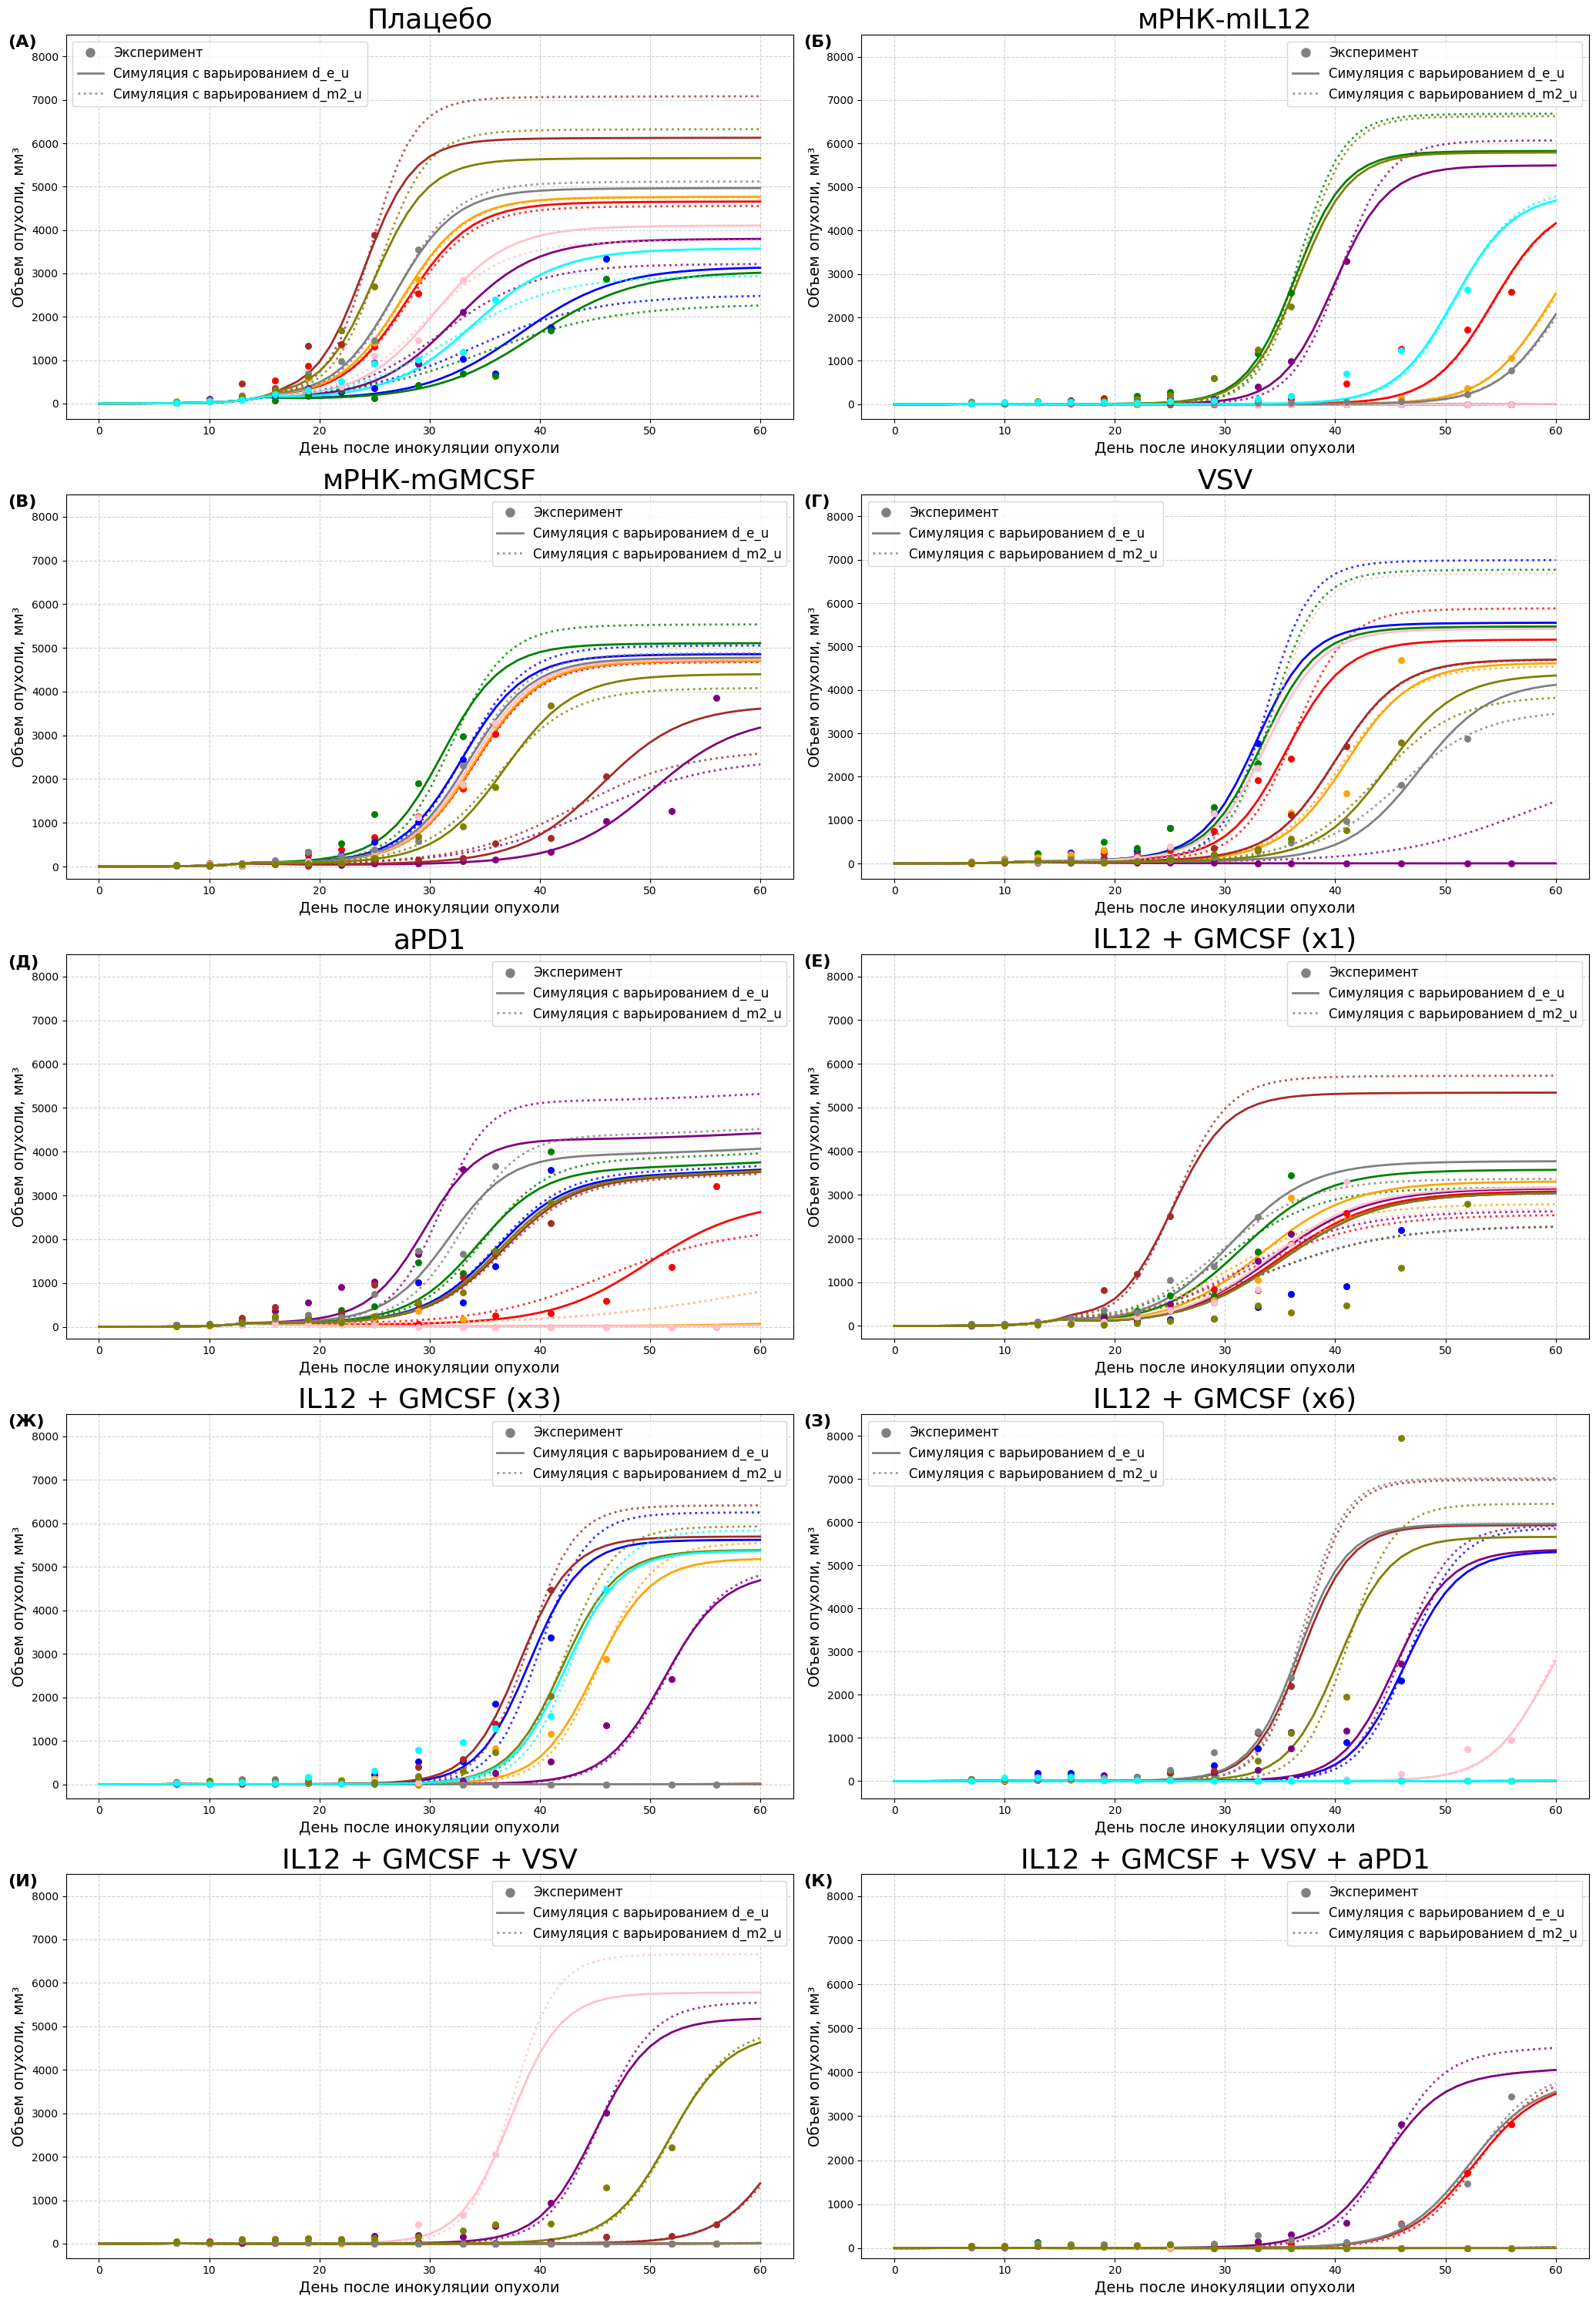

(<Figure size 2000x3000 with 10 Axes>,
 array([[<Axes: title={'center': 'Плацебо'}, xlabel='День после инокуляции опухоли', ylabel='Объем опухоли, мм³'>,
         <Axes: title={'center': 'мРНК-mIL12'}, xlabel='День после инокуляции опухоли', ylabel='Объем опухоли, мм³'>],
        [<Axes: title={'center': 'мРНК-mGMCSF'}, xlabel='День после инокуляции опухоли', ylabel='Объем опухоли, мм³'>,
         <Axes: title={'center': 'VSV'}, xlabel='День после инокуляции опухоли', ylabel='Объем опухоли, мм³'>],
        [<Axes: title={'center': 'aPD1'}, xlabel='День после инокуляции опухоли', ylabel='Объем опухоли, мм³'>,
         <Axes: title={'center': 'IL12 + GMCSF (x1)'}, xlabel='День после инокуляции опухоли', ylabel='Объем опухоли, мм³'>],
        [<Axes: title={'center': 'IL12 + GMCSF (x3)'}, xlabel='День после инокуляции опухоли', ylabel='Объем опухоли, мм³'>,
         <Axes: title={'center': 'IL12 + GMCSF (x6)'}, xlabel='День после инокуляции опухоли', ylabel='Объем опухоли, мм³'>],
       

In [9]:
plot_all_mice_together_subplots_multifile(
        excel_files = [
                       "Tables/mice_without_treatment_d_e_u_d_m2_u.xlsx",
                       "Tables/mice_IL12_d_e_u_d_m2_u.xlsx",
                       "Tables/mice_GMCSF_d_e_u_d_m2_u.xlsx",
                       "Tables/mice_VSV_d_e_u_d_m2_u.xlsx",
                       "Tables/mice_aPD1_d_e_u_d_m2_u.xlsx",
                       "Tables/mice_IL12_GMCSF_x1_d_e_u_d_m2_u.xlsx",
                       "Tables/mice_IL12_GMCSF_x3_d_e_u_d_m2_u.xlsx",
                       "Tables/mice_IL12_GMCSF_x6_d_e_u_d_m2_u.xlsx",
                       "Tables/mice_IL12_GMCSF_VSV_d_e_u_d_m2_u.xlsx",
                       "Tables/mice_IL12_GMCSF_VSV_aPD1_d_e_u_d_m2_u.xlsx"
                       ],
        sheet_names_list = [
                            ["mouse_1", "mouse_2", "mouse_3", "mouse_4", "mouse_5", "mouse_6", "mouse_7", "mouse_8", "mouse_9", "mouse_10"],
                            ["mouse_1", "mouse_2", "mouse_3", "mouse_4", "mouse_5", "mouse_6", "mouse_7", "mouse_8", "mouse_9", "mouse_10"],
                            ["mouse_1", "mouse_2", "mouse_3", "mouse_4", "mouse_5", "mouse_6", "mouse_7", "mouse_8", "mouse_9"],
                            ["mouse_1", "mouse_2", "mouse_3", "mouse_4", "mouse_5", "mouse_6", "mouse_7", "mouse_8", "mouse_9"],
                            ["mouse_1", "mouse_2", "mouse_3", "mouse_4", "mouse_5", "mouse_6", "mouse_7", "mouse_8", "mouse_9"],
                            ["mouse_1", "mouse_2", "mouse_3", "mouse_4", "mouse_5", "mouse_6", "mouse_7", "mouse_8", "mouse_9"],
                            ["mouse_1", "mouse_2", "mouse_3", "mouse_4", "mouse_5", "mouse_6", "mouse_7", "mouse_8", "mouse_9", "mouse_10"],
                            ["mouse_1", "mouse_2", "mouse_3", "mouse_4", "mouse_5", "mouse_6", "mouse_7", "mouse_8", "mouse_9", "mouse_10"],
                            ["mouse_1", "mouse_2", "mouse_3", "mouse_4", "mouse_5", "mouse_6", "mouse_7", "mouse_8", "mouse_9"],
                            ["mouse_1", "mouse_2", "mouse_3", "mouse_4", "mouse_5", "mouse_6", "mouse_7", "mouse_8", "mouse_9"]
                            ],
        x_col_list = ["Days", "Days", "Days", "Days", "Days", "Days", "Days", "Days", "Days", "Days"],
        exp_col_list = ["Experiment", "Experiment", "Experiment", "Experiment", "Experiment", "Experiment", "Experiment", "Experiment", "Experiment", "Experiment"],
        sim_col_list = ["Simulation_d_e_u", "Simulation_d_e_u", "Simulation_d_e_u", "Simulation_d_e_u", "Simulation_d_e_u", "Simulation_d_e_u", "Simulation_d_e_u", "Simulation_d_e_u", "Simulation_d_e_u", "Simulation_d_e_u"],
        sim2_col_list = ["Simulation_d_m2_u", "Simulation_d_m2_u", "Simulation_d_m2_u", "Simulation_d_m2_u", "Simulation_d_m2_u", "Simulation_d_m2_u", "Simulation_d_m2_u", "Simulation_d_m2_u", "Simulation_d_m2_u", "Simulation_d_m2_u"],
        plot_titles = ["Плацебо", "мРНК-mIL12", "мРНК-mGMCSF", "VSV", "aPD1", "IL12 + GMCSF (x1)", "IL12 + GMCSF (x3)", "IL12 + GMCSF (x6)", "IL12 + GMCSF + VSV", "IL12 + GMCSF + VSV + aPD1"],
        #xlabel = "Days after tumor inoculation",
        #ylabel = "Tumor volume, mm³",
        xlabels = [
                   "День после инокуляции опухоли",
                   "День после инокуляции опухоли",
                   "День после инокуляции опухоли",
                   "День после инокуляции опухоли",
                   "День после инокуляции опухоли",
                   "День после инокуляции опухоли",
                   "День после инокуляции опухоли",
                   "День после инокуляции опухоли",
                   "День после инокуляции опухоли",
                   "День после инокуляции опухоли"
                   ],
        ylabels = [
                   "Объем опухоли, мм³",
                   "Объем опухоли, мм³",
                   "Объем опухоли, мм³",
                   "Объем опухоли, мм³",
                   "Объем опухоли, мм³",
                   "Объем опухоли, мм³",
                   "Объем опухоли, мм³",
                   "Объем опухоли, мм³",
                   "Объем опухоли, мм³",
                   "Объем опухоли, мм³"
                  ],
        colors_list = [
                       ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'],
                       ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'],
                       ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive'],
                       ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive'],
                       ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive'],
                       ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive'],
                       ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'],
                       ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'],
                       ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive'],
                       ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive']
                       ],
        exp_type_list = [".", ".", ".", ".", ".", ".", ".", ".", ".", "."],
        y_upper_limits=[8500, 8500, 8500, 8500, 8500, 8500, 8500, 8500, 8500, 8500],
        #legend_labels_list = [["Мышь 1", "Мышь 2", "Мышь 3", "Мышь 4", "Мышь 5", "Мышь 6", "Мышь 7", "Мышь 8", "Мышь 9", "Мышь 10"]],
        #legend_ncol = 5,
        legend_fontsize=12,
        xlabel_fontsize=14,
        ylabel_fontsize=14,
        title_fontsize=26,  # как в plot_tumor_growth_comparison
        plot_width=20,  # как в plot_tumor_growth_comparison
        plot_height=30,   # как в plot_tumor_growth_comparison
        legend_type='simple',
        n_cols=2,
        subplot_signs=['(А)', '(Б)', '(В)', '(Г)', '(Д)', '(Е)', '(Ж)', '(З)', '(И)', '(К)']
    )

## Create plot to visualize model simulation treatments for mice from placebo group

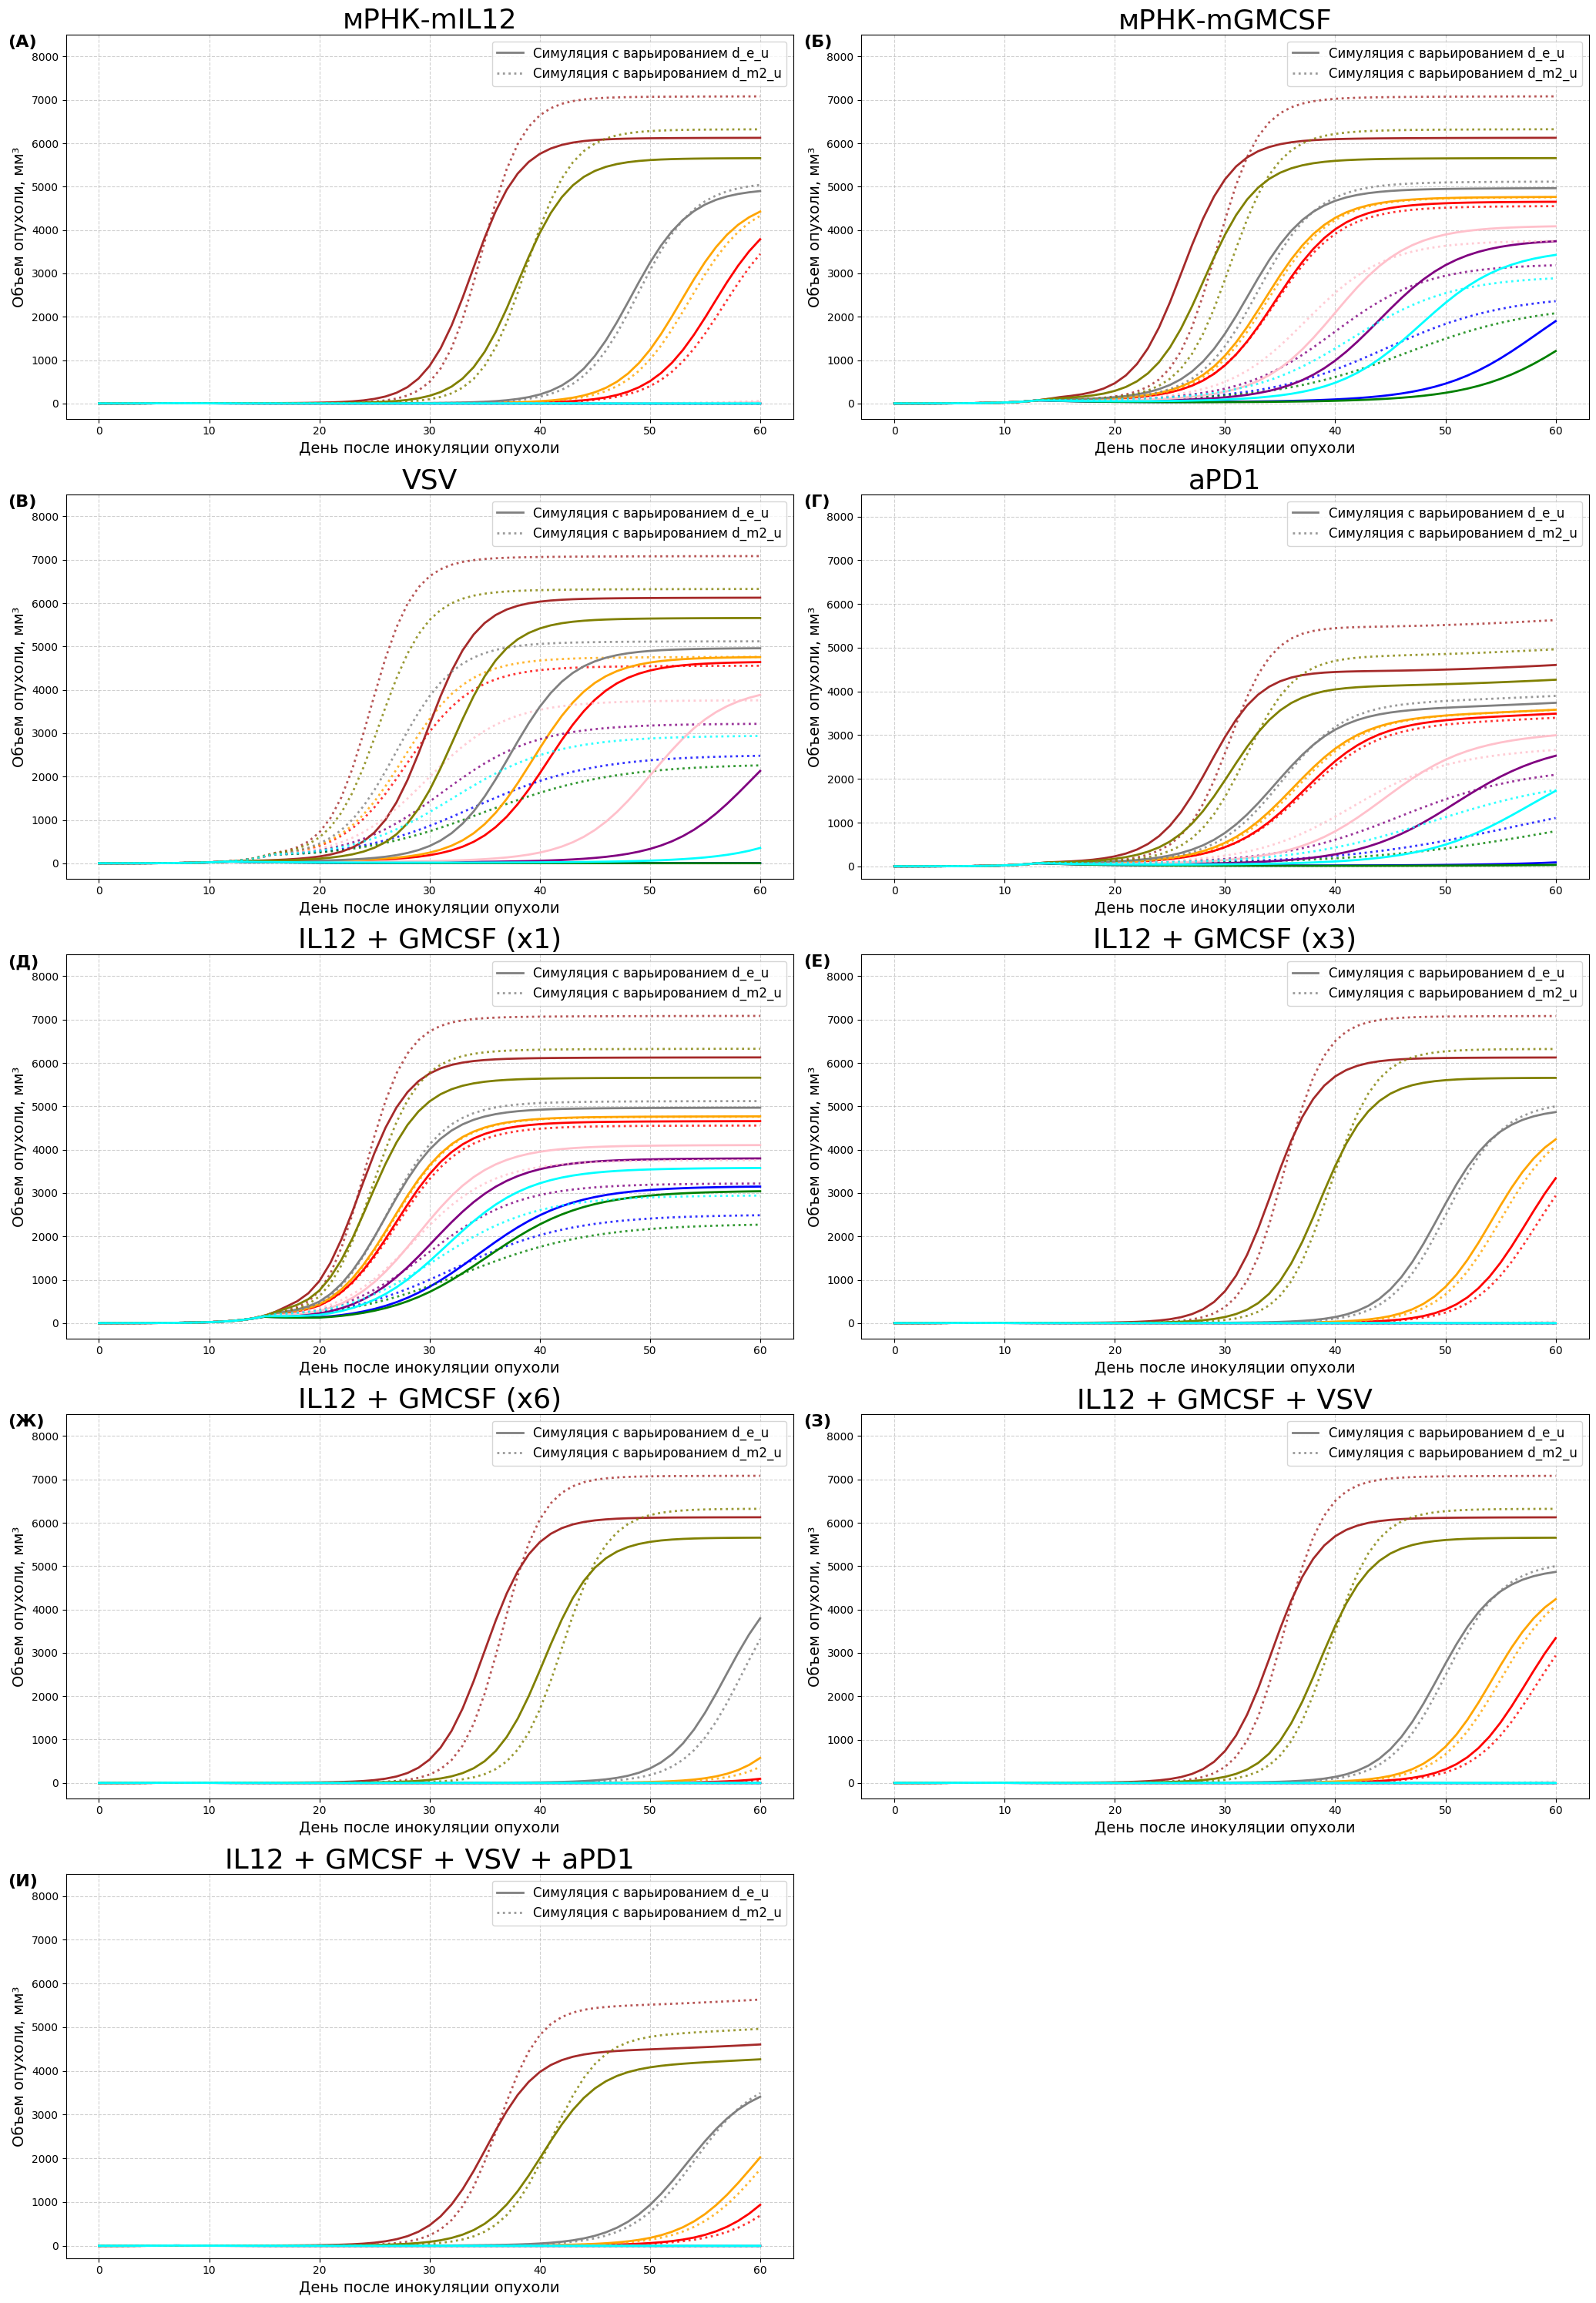

(<Figure size 2000x3000 with 10 Axes>,
 array([[<Axes: title={'center': 'мРНК-mIL12'}, xlabel='День после инокуляции опухоли', ylabel='Объем опухоли, мм³'>,
         <Axes: title={'center': 'мРНК-mGMCSF'}, xlabel='День после инокуляции опухоли', ylabel='Объем опухоли, мм³'>],
        [<Axes: title={'center': 'VSV'}, xlabel='День после инокуляции опухоли', ylabel='Объем опухоли, мм³'>,
         <Axes: title={'center': 'aPD1'}, xlabel='День после инокуляции опухоли', ylabel='Объем опухоли, мм³'>],
        [<Axes: title={'center': 'IL12 + GMCSF (x1)'}, xlabel='День после инокуляции опухоли', ylabel='Объем опухоли, мм³'>,
         <Axes: title={'center': 'IL12 + GMCSF (x3)'}, xlabel='День после инокуляции опухоли', ylabel='Объем опухоли, мм³'>],
        [<Axes: title={'center': 'IL12 + GMCSF (x6)'}, xlabel='День после инокуляции опухоли', ylabel='Объем опухоли, мм³'>,
         <Axes: title={'center': 'IL12 + GMCSF + VSV'}, xlabel='День после инокуляции опухоли', ylabel='Объем опухоли, мм³'

In [10]:
plot_all_mice_together_subplots_multifile(
        excel_files = [
                       "Tables/control_mice_treated_IL12.xlsx",
                       "Tables/control_mice_treated_GMCSF.xlsx",
                       "Tables/control_mice_treated_VSV.xlsx",
                       "Tables/control_mice_treated_aPD1.xlsx",
                       "Tables/control_mice_treated_IL12_GMCSF_x1.xlsx",
                       "Tables/control_mice_treated_IL12_GMCSF_x3.xlsx",
                       "Tables/control_mice_treated_IL12_GMCSF_x6.xlsx",
                       "Tables/control_mice_treated_IL12_GMCSF_VSV.xlsx",
                       "Tables/control_mice_treated_IL12_GMCSF_VSV_aPD1.xlsx"
                       ],
        sheet_names_list = [
                            ["mouse 1", "mouse 2", "mouse 3", "mouse 4", "mouse 5", "mouse 6", "mouse 7", "mouse 8", "mouse 9", "mouse 10"],
                            ["mouse 1", "mouse 2", "mouse 3", "mouse 4", "mouse 5", "mouse 6", "mouse 7", "mouse 8", "mouse 9", "mouse 10"],
                            ["mouse 1", "mouse 2", "mouse 3", "mouse 4", "mouse 5", "mouse 6", "mouse 7", "mouse 8", "mouse 9", "mouse 10"],
                            ["mouse 1", "mouse 2", "mouse 3", "mouse 4", "mouse 5", "mouse 6", "mouse 7", "mouse 8", "mouse 9", "mouse 10"],
                            ["mouse 1", "mouse 2", "mouse 3", "mouse 4", "mouse 5", "mouse 6", "mouse 7", "mouse 8", "mouse 9", "mouse 10"],
                            ["mouse 1", "mouse 2", "mouse 3", "mouse 4", "mouse 5", "mouse 6", "mouse 7", "mouse 8", "mouse 9", "mouse 10"],
                            ["mouse 1", "mouse 2", "mouse 3", "mouse 4", "mouse 5", "mouse 6", "mouse 7", "mouse 8", "mouse 9", "mouse 10"],
                            ["mouse 1", "mouse 2", "mouse 3", "mouse 4", "mouse 5", "mouse 6", "mouse 7", "mouse 8", "mouse 9", "mouse 10"],
                            ["mouse 1", "mouse 2", "mouse 3", "mouse 4", "mouse 5", "mouse 6", "mouse 7", "mouse 8", "mouse 9", "mouse 10"]
                            ],
        x_col_list = [
                      "Days",
                      "Days",
                      "Days",
                      "Days", 
                      "Days",
                      "Days",
                      "Days",
                      "Days",
                      "Days"
                      ],
        #exp_col_list = [
                #        "Experiment",
                #        "Experiment",
                 #       "Experiment",
                 #       "Experiment",
                  #      "Experiment",
                  #      "Experiment",
                 #       "Experiment",
                   #     "Experiment",
                 #       "Experiment"
                  #      ],
        sim_col_list = [
                        "Simulation_d_e_u",
                        "Simulation_d_e_u",
                        "Simulation_d_e_u",
                        "Simulation_d_e_u",
                        "Simulation_d_e_u",
                        "Simulation_d_e_u",
                        "Simulation_d_e_u",
                        "Simulation_d_e_u",
                        "Simulation_d_e_u"],
        sim2_col_list = [
                        "Simulation_d_m2_u",
                        "Simulation_d_m2_u",
                        "Simulation_d_m2_u",
                        "Simulation_d_m2_u",
                        "Simulation_d_m2_u",
                        "Simulation_d_m2_u",
                        "Simulation_d_m2_u",
                        "Simulation_d_m2_u",
                        "Simulation_d_m2_u"
                        ],
        plot_titles = [
                      "мРНК-mIL12",
                      "мРНК-mGMCSF",
                      "VSV",
                      "aPD1",
                      "IL12 + GMCSF (x1)",
                      "IL12 + GMCSF (x3)",
                      "IL12 + GMCSF (x6)",
                      "IL12 + GMCSF + VSV",
                      "IL12 + GMCSF + VSV + aPD1"
                      ],
        #xlabel = "Days after tumor inoculation",
        #ylabel = "Tumor volume, mm³",
        xlabels = [
                   "День после инокуляции опухоли",
                   "День после инокуляции опухоли",
                   "День после инокуляции опухоли",
                   "День после инокуляции опухоли",
                   "День после инокуляции опухоли",
                   "День после инокуляции опухоли",
                   "День после инокуляции опухоли",
                   "День после инокуляции опухоли",
                   "День после инокуляции опухоли"
                   ],
        ylabels = [
                   "Объем опухоли, мм³",
                   "Объем опухоли, мм³",
                   "Объем опухоли, мм³",
                   "Объем опухоли, мм³",
                   "Объем опухоли, мм³",
                   "Объем опухоли, мм³",
                   "Объем опухоли, мм³",
                   "Объем опухоли, мм³",
                   "Объем опухоли, мм³"
                  ],
        colors_list = [
                       ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'],
                       ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'],
                       ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'],
                       ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'],
                       ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'],
                       ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'],
                       ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'],
                       ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'],
                       ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
                       ],
        exp_type_list = [".", ".", ".", ".", ".", ".", ".", ".", "."],
        y_upper_limits=[8500, 8500, 8500, 8500, 8500, 8500, 8500, 8500, 8500],
        #legend_labels_list = [["Мышь 1", "Мышь 2", "Мышь 3", "Мышь 4", "Мышь 5", "Мышь 6", "Мышь 7", "Мышь 8", "Мышь 9", "Мышь 10"]],
        #legend_ncol = 5,
        legend_fontsize=12,
        xlabel_fontsize=14,
        ylabel_fontsize=14,
        title_fontsize=26,  # как в plot_tumor_growth_comparison
        plot_width=20,  # как в plot_tumor_growth_comparison
        plot_height=30,   # как в plot_tumor_growth_comparison
        legend_type='simple',
        n_cols=2,
        subplot_signs=['(А)', '(Б)', '(В)', '(Г)', '(Д)', '(Е)', '(Ж)', '(З)', '(И)']
    )